In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from numpy.random import RandomState
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import os
import re
import glob
pd.set_option('display.max_colwidth', -1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if sys.path[0] == '':


In [2]:
labeled_data = pd.read_pickle('./data/labeled_data_df.pkl')
labeled_data.shape

(682595, 4)

In [3]:
labeled_data.type.value_counts()

twint_tweet               520886
dallas_news_predicted     114686
dallas_news               40309 
mturk_zh_backtrans        2050  
mturk                     2050  
mturk_french_backtrans    2050  
semeval_train_tweets      395   
semeval_tweets            169   
Name: type, dtype: int64

In [4]:
labeled_data.columns

Index(['source', 'type', 'text', 'stance'], dtype='object')

In [49]:
stances = ["agrees", "neutral", "disagrees"]
class_nums = {s: i for i, s in enumerate(stances)}

In [6]:
labeled_data.head()

,source,type,text,stance
0,climate_change1.0-12174 [SEP] 0,dallas_news,It's about seeing the forest and the trees in Calif.; Scientists study global warming's effect on redwoods and sequoias,agree
1,climate_change1.0-12174 [SEP] 1,dallas_news,Two of his colleagues dangled on ropes 100 feet above from the gnarled branches of a giant sequoia tree.,agree
2,climate_change1.0-12174 [SEP] 2,dallas_news,Steve Sillett could hardly contain his excitement.,agree
3,climate_change1.0-12174 [SEP] 3,dallas_news,"""This site is just juicy.",agree
4,climate_change1.0-12174 [SEP] 4,dallas_news,"It's loaded,"" said Sillett, gazing up at the ancient canopy at Calaveras Big Trees State Park.",agree


In [85]:
#labeled_data.to_pickle('./data/labeled_data_df.pkl')

# Vaccines data

In [115]:
vax_dir = '/Users/yiweiluo/vaccination_stance'

In [116]:
vax_stances = ['for','uncertain','against']
vax_class_nums = {s: i for i, s in enumerate(vax_stances)}

In [113]:
vax_labeled_dat = {'type':[],'text':[],'stance':[]}
#vax_labeled_dat_df = pd.read_pickle('./data/vax_labeled_data_df.pkl')

## Get Skeppstedt annotated forum data

In [167]:
for_files = glob.glob(os.path.join(vax_dir,'train_data','for','*.txt'))
uncertain_files = glob.glob(os.path.join(vax_dir,'train_data','uncertain','*.txt'))
against_files = glob.glob(os.path.join(vax_dir,'train_data','against','*.txt'))
len(for_files),len(uncertain_files),len(against_files)

(430, 238, 462)

In [168]:
for_texts = []
for file in for_files:
    with open(file,'r') as f:
        for_texts.append(f.read().strip())
        
uncertain_texts = []
for file in uncertain_files:
    with open(file,'r') as f:
        uncertain_texts.append(f.read().strip())
        
against_texts = []
for file in against_files:
    with open(file,'r') as f:
        against_texts.append(f.read().strip())
        
len(for_texts),len(uncertain_texts),len(against_texts)

(430, 238, 462)

In [169]:
sentences = for_texts + uncertain_texts + against_texts 
len(sentences)

1130

In [119]:
texts_by_stance = {'for':for_texts,'uncertain':uncertain_texts,'against':against_texts}

In [170]:
for_texts[5] 
# Skeppstedt data is multiple sentences. Split? But individual sentence might not reflect overall stance...

'Rosi, one very anti-vaccine doctor only goes to prove that one doctor is against vaccination, not that vaccines are dangerous. One smoking doctor does not prove that smoking is harmless, just that doctors are humans and can be irrational. Loibner, who has been an anti-vaccine activist for decades, is really not suitable as a proof for a recent trend in vaccine refusal amongst doctors.'

In [120]:
for stance in vax_stances:
    vax_labeled_dat['type'].extend(['skeppstedt']*len(texts_by_stance[stance]))
    vax_labeled_dat['stance'].extend([stance]*len(texts_by_stance[stance]))
    vax_labeled_dat['text'].extend(texts_by_stance[stance])

In [121]:
vax_labeled_dat_df = pd.DataFrame(vax_labeled_dat)

In [122]:
vax_labeled_dat_df.shape

(1130, 3)

## My manually annotated clauses

In [123]:
vax_label_dict = {0: 'for', 1: 'against', 2: 'neutral'}

In [106]:
base_dir = '/Users/yiweiluo/Dropbox/research/QP2/code/Fox_and_friends/'
anti_tetrads_results = pd.read_csv(base_dir+'on_topic_anti_vax_tetrads_with_subject_verb_filtered.csv',header=None,
                                  encoding = "ISO-8859-1")
pro_tetrads_results = pd.read_csv(base_dir+'on_topic_pro_vax_tetrads_with_subject_verb_filtered.csv',header=None,
                                  encoding = "ISO-8859-1")

In [108]:
anti_tetrads_results.columns = ['subj','neg','v','sentence','stance','source','notes','subj_ent']
pro_tetrads_results.columns = ['subj','neg','v','sentence','stance','source','notes','subj_ent']
all_manual_vax = anti_tetrads_results.append(pro_tetrads_results,ignore_index=True)

In [109]:
all_manual_vax

,subj,neg,v,sentence,stance,source,notes,subj_ent
0,authors,NaN,acknowledged,that â such an outbreak should have been virtually impossible,0,sent_no_26 of https://childrenshealthdefense.org/news/herd-immunity-a-false-rationale-for-vaccine-mandates/,NaN,s
1,.I,NaN,say,tics are four times more prevalent in kids with autism,1,sent_no_17 of https://childrenshealthdefense.org/uncategorized/cdc-scientist-still-maintains-agency-forced-researchers-lie-safety-mercury-based-vaccines/,NaN,NaN
2,New York Times,NaN,claimed,that the science showed that the vaccine represented â a big payoff in public health â and that harms from the vaccine were â almost nonexistent â,0,sent_no_4 of https://childrenshealthdefense.org/news/how-the-cdc-uses-fear-to-increase-demand-for-flu-vaccines/,NaN,p
3,I,NaN,say,tics are four times more prevalent in kids with autism,1,sent_no_67 of https://childrenshealthdefense.org/news/get-flu-shot-cdc-data-raise-concerns/,NaN,NaN
4,awards,NaN,recognize,that many of the chronic diseases that suddenly became epidemic in our children following the passage of NCVIA can be caused by vaccines or their ingredients,1,sent_no_53 of https://childrenshealthdefense.org/news/vaccines-and-the-liberal-mind/,NaN,NaN
...,...,...,...,...,...,...,...,...
995,Rabinowitz,NaN,added,"that for patients with celiac disease , vaccines such as the flu vaccine are very important",0,sent_no_18 of https://www.foxnews.com/health/some-people-who-avoid-gluten-also-avoid-vaccines,NaN,doc
996,it,NaN,ensure,"that it is not influenced by politics , such as pressure from officials to play down an outbreak that may affect tourism or trade , in raising international alarms",2,sent_no_15 of https://www.nytimes.com/2015/12/30/opinion/nearing-triumph-over-ebola.html?searchResultPosition=3,NaN,NaN
997,committee,NaN,decided,that nasal flu vaccine (the brand name is FluMist) nasal flu vaccine (the brand name is FluMist) nasal flu vaccine (the brand name is FluMist) nasal flu vaccine (the brand name is FluMist) nasal flu vaccine (the brand name is FluMist) nasal flu vaccine (the brand name is FluMist) nasal flu vaccine (the brand name is FluMist) nasal flu vaccine (the brand name is FluMist) nasal flu vaccine (the brand name is FluMist) nasal flu vaccine (the brand name is FluMist) should no longer be used because it has been less effective in protecting people the past couple of flu seasons,2,sent_no_3 of https://www.nytimes.com/2016/10/03/well/family/a-flu-season-without-flumist-making-shots-less-painful-for-children.html?searchResultPosition=66,NaN,dept
998,i,NaN,reassure,that vaccines are safe,0,sent_no_8 of https://www.foxnews.com/health/with-most-cases-centering-on-new-york-city-us-measles-count-nears-1000-toppling-records,NaN,NaN


In [110]:
all_manual_vax.stance.value_counts()

2    497
1    265
0    238
Name: stance, dtype: int64

In [111]:
497+265+238

1000

In [125]:
texts_by_stance = {'for':all_manual_vax.loc[all_manual_vax.stance==0].sentence.values,
                   'uncertain':all_manual_vax.loc[all_manual_vax.stance==2].sentence.values,
                   'against':all_manual_vax.loc[all_manual_vax.stance==1].sentence.values,}

In [126]:
for stance in vax_stances:
    vax_labeled_dat['type'].extend(['my_annotations']*len(texts_by_stance[stance]))
    vax_labeled_dat['stance'].extend([stance]*len(texts_by_stance[stance]))
    vax_labeled_dat['text'].extend(texts_by_stance[stance])

In [127]:
vax_labeled_dat_df = pd.DataFrame(vax_labeled_dat)
vax_labeled_dat_df.shape

(2130, 3)

In [128]:
vax_labeled_dat_df.to_pickle('./data/vax_labeled_data_df.pkl')

## Unlabeled vaccine data for LM fine-tuning

In [170]:
for_files = glob.glob(os.path.join(vax_dir,'my_train_data','for','*.txt'))
uncertain_files = glob.glob(os.path.join(vax_dir,'my_train_data','uncertain','*.txt'))
against_files = glob.glob(os.path.join(vax_dir,'my_train_data','against','*.txt'))
len(for_files),len(uncertain_files),len(against_files)

(434, 127, 933)

In [171]:
for_texts = []
for file in for_files:
    with open(file,'r') as f:
        for_texts.append(f.read().strip().replace('\t',''))
        
uncertain_texts = []
for file in uncertain_files:
    with open(file,'r') as f:
        uncertain_texts.append(f.read().strip().replace('\t',''))
        
against_texts = []
for file in against_files:
    with open(file,'r') as f:
        against_texts.append(f.read().strip().replace('\t',''))
        
len(for_texts),len(uncertain_texts),len(against_texts)

(434, 127, 933)

In [172]:
print(len(sentences))
sentences.extend(for_texts + uncertain_texts + against_texts)
print(len(sentences))

1130
2624


In [179]:
df = pd.read_pickle('../../data_scraping/dedup_combined_df.pkl')
df.head(10)

,url,title,date,domain,stance,topic,is_AP,year,pretty_domain
0,www.buzzfeednews.com/article/tasneemnashrulla/eat-babies-aoc-town-hall-pro-trump-troll-larouche,"""eat the babies"" viral video at aoc town hall was staged ...",2019-10-04 00:00:00,buzzfeed,pro,cc,None,2019.0,Buzzfeed
1,www.buzzfeednews.com/article/passantino/extremely-likely-global-warming-is-man-made-climate-scientis,"""extremely likely"" global warming is man-made, climate ...",2013-09-27 00:00:00,buzzfeed,pro,cc,None,2013.0,Buzzfeed
2,shotofprevention.com/2010/11/03/history-makes-headlines-with-launch-of-new-website/,"""history"" makes headlines with launch of new website",2020-03-13 14:32:02,https://shotofprevention/,pro,vax,False,2020.0,Shot of Prevention
3,www.buzzfeednews.com/article/andrewkaczynski/its-global-warming-stupid,"""it's global warming, stupid"" - buzzfeed news",2012-11-01 00:00:00,buzzfeed,pro,cc,None,2012.0,Buzzfeed
4,www.buzzfeednews.com/article/tasneemnashrulla/japan-dropped-an-atomic-bomb-on-america-during-world-war-ii,"""japan dropped an atomic bomb on america during world ...",2014-02-24 00:00:00,buzzfeed,pro,cc,None,2014.0,Buzzfeed
5,www.buzzfeednews.com/article/llevin/opinion-im-18-and-joe-biden-couldnt-answer-my-questions-how,"""look at my record, child"": joe biden showed me he's not ...",2019-10-31 00:00:00,buzzfeed,pro,cc,None,2019.0,Buzzfeed
6,www.breitbart.com/politics/2019/06/14/orourke-president-orourke-will-take-executive-action-to-end-new-oil-and-gas-leases-on-federal-lands/,"""president o'rourke will end oil and gas leases on federal ...",2019-06-14 00:00:00,breitbart,anti,cc,None,2019.0,Breitbart
7,www.buzzfeednews.com/article/andrewkaczynski/smoking-doesnt-kill-and-other-great-old-op-eds-from-mike-pen,smoking doesnt kill and other great old opeds from mike pence,2015-03-31 00:00:00,buzzfeed,pro,cc,None,2015.0,Buzzfeed
8,www.foxnews.com/world/100-carbon-tax-by-2030-could-save-climate-say-economists,"$100 carbon tax by 2030 could save climate, say economists ...",2017-05-29 00:00:00,fox,anti,cc,None,2017.0,Fox
21585,childrenshealthdefense.org/news/4-billion-and-growing-u-s-payouts-for-vaccine-injuries-and-deaths-keep-climbing/,$4 billion and growing: u.s. payouts for vaccine injuries and deaths keep climbing,2018-11-19 00:00:00,chd,anti,vax,None,2018.0,Children's Health Defense


In [180]:
vax_df = df.loc[df.topic == 'vax']
vax_df.shape

(2530, 9)

In [181]:
os.chdir('../../')
print(os.getcwd())
from utils import get_fulltext,get_fname,fulltext_exists
os.chdir('./cc_stance/data_creation/')

/Users/yiweiluo/scientific-debates


In [185]:
train_ix,test_ix = train_test_split(list(range(len(sentences))),test_size=0.3)
len(train_ix),len(test_ix)

(1836, 788)

In [186]:
train_ix,test_ix = train_test_split(list(range(len(sentences))),test_size=0.3)
len(train_ix),len(test_ix)

(1836, 788)

In [187]:
train_sents = [sentences[ix] for ix in train_ix]
test_sents = [sentences[ix] for ix in test_ix]
len(train_sents),len(test_sents)

(1836, 788)

In [188]:
train_sents[:3]

['In addition to those 400 chronic diseases and injuries that FDA suspects may be vaccine related, the vaccine generation suffers unprecedented levels of anxiety and depression and behavioral disorders running the gamut from aggression to anorexia.',
 'The types of studies the CDC has relied on to support this claim have been thoroughly discredited due to their systemic “healthy user” selection bias, and the mortality rate has observably increased along with the increase in vaccine uptake—which the CDC has encouraged with its unevidenced claims about the vaccine’s benefits, downplaying of its risks, and a marketing strategy of trying to frighten people into getting the flu shot for themselves and their family.',
 'Titre studies are unable to differentiate vaccine derived antibodies and those derived from natural infection so it is felt transfer in colostrum is no different in fact studies in cattle and sheep have shown it is not. The most effective antibody transfer occurs in colostrum

In [184]:
vax_df_train,vax_df_test = train_test_split(vax_df.url.values,test_size=0.2)
len(vax_df_train),len(vax_df_test)

(2024, 506)

In [192]:
with open('all.vax.fulltexts.uncased.train.raw','w+') as f:
    for url in vax_df_train:
        f.write(' '.join(get_fulltext(url)).lower())
        f.write('\n')
    for s in train_sents:
        f.write(s.lower()+' ')
        
with open('all.vax.fulltexts.uncased.test.raw','w+') as f:
    for url in vax_df_test:
        f.write(' '.join(get_fulltext(url)).lower())
        f.write('\n')
    for s in test_sents:
        f.write(s.lower()+' ')

## Create train/test/dev splits

In [143]:
data_type = 'both_vax' # 'my_annotations','skeppstedt','both_vax',None
do_downsample = False

if do_downsample:
    SAVE_DIR = './scripts/save/{}_downsampled/'.format(data_type)
else:
    SAVE_DIR = './scripts/save/{}/'.format(data_type)
print(SAVE_DIR)
if not os.path.exists(SAVE_DIR):
    os.mkdir(SAVE_DIR)

if data_type != 'both_vax':
    data_df = vax_labeled_dat_df.loc[vax_labeled_dat_df.type == data_type]
else:
    data_df = vax_labeled_dat_df

if data_df is not None:
    print(data_df.shape) 

./scripts/save/both_vax/
(2130, 3)


In [150]:
vax_labeled_dat_df.index

RangeIndex(start=0, stop=2130, step=1)

In [151]:
train_ix,eval_ix = train_test_split(vax_labeled_dat_df.loc[vax_labeled_dat_df.type=='my_annotations']\
                                    .index.values,test_size=300)
len(train_ix),len(eval_ix)

(700, 300)

In [152]:
SHARED_EVAL_IX = eval_ix.copy()

In [153]:
dev_ix,test_ix = train_test_split(eval_ix,test_size=200)
len(dev_ix),len(test_ix)

(100, 200)

In [155]:
train_df = data_df[~data_df.index.isin(SHARED_EVAL_IX)]
dev_df = data_df.loc[dev_ix]
test_df = data_df.loc[test_ix]
print(train_df.shape,dev_df.shape,test_df.shape)

(1830, 3) (100, 3) (200, 3)


## Writing to files

In [156]:
train_df_by_stance = {s: train_df.loc[train_df.stance == s] for s in vax_stances} if train_df is not None else None
dev_df_by_stance = {s: dev_df.loc[dev_df.stance == s] for s in vax_stances}
test_df_by_stance = {s: test_df.loc[test_df.stance == s] for s in vax_stances}

train_X_by_stance = {s: train_df_by_stance[s].text.values for i,s in enumerate(vax_stances)} if train_df is not None else None
dev_X_by_stance = {s: dev_df_by_stance[s].text.values for i,s in enumerate(vax_stances)}
test_X_by_stance = {s: test_df_by_stance[s].text.values for i,s in enumerate(vax_stances)}

train_Y_by_stance = {s: np.array([vax_class_nums[x] for x in train_df_by_stance[s].stance]) for i,s in enumerate(vax_stances)} if train_df is not None else None
dev_Y_by_stance = {s: np.array([vax_class_nums[x] for x in dev_df_by_stance[s].stance]) for i,s in enumerate(vax_stances)}
test_Y_by_stance = {s: np.array([vax_class_nums[x] for x in test_df_by_stance[s].stance]) for i,s in enumerate(vax_stances)}

if do_downsample:
    min_N = min([len(train_X_by_stance[s]) for s in vax_stances])
    print('Downsampling to ~{} examples per stance.'.format(min_N))
    for s in vax_stances:
        train_X_by_stance[s] = train_X_by_stance[s][:min_N+50]

if train_df is not None:
    trX = []
    trY = []
    for i,s in enumerate(vax_stances):
        for t, y in zip(train_X_by_stance[s], train_Y_by_stance[s]):
            trX.append(t)
            trY.append(y)

teX = []
teY = []
for i,s in enumerate(vax_stances):
    for t, y in zip(test_X_by_stance[s], test_Y_by_stance[s]):
        teX.append(t)
        teY.append(y)

vaX = []
vaY = []
for i,s in enumerate(vax_stances):
    for t, y in zip(dev_X_by_stance[s], dev_Y_by_stance[s]):
        vaX.append(t)
        vaY.append(y)
        
        
test_dat = pd.DataFrame({'sentence':teX,'stance':teY})
train_dat = pd.DataFrame({'sentence':trX,'stance':trY}) if train_df is not None else None
val_dat = pd.DataFrame({'sentence':vaX,'stance':vaY})
if train_df is not None:
    print('Train distribution:')
    print(train_dat.stance.value_counts()) 
print('\nDev distribution:')
print(val_dat.stance.value_counts())
print('\nTest distribution:')
print(test_dat.stance.value_counts())

if train_df is not None:
    train_dat.to_csv(SAVE_DIR+'train.tsv',sep='\t',header=None,index=False)
val_dat.to_csv(SAVE_DIR+'dev.tsv',sep='\t',header=None,index=False)
test_dat.to_csv(SAVE_DIR+'test.tsv',sep='\t',header=None,index=False)

Train distribution:
2    649
0    610
1    571
Name: stance, dtype: int64

Dev distribution:
1    56
2    26
0    18
Name: stance, dtype: int64

Test distribution:
1    108
2    52 
0    40 
Name: stance, dtype: int64


# Vanilla MTurk--Dallas estimated true labels

In [ ]:
dallas_sentence_scores = pd.read_csv('/Users/yiweiluo/scientific-debates/\
cc_stance/MTurk/MTurk_results/sent_scores_df.tsv',delimiter='\t')
dallas_sentence_scores['max_prob_label'] = dallas_sentence_scores[['disagree',
                                                                  'neutral',
                                                                  'agree']].idxmax(axis=1)
dallas_sentence_scores.shape

In [ ]:
mturk_data_df = pd.DataFrame({
    'source':['round{}_batch{}_sentid{}'.format(row['round'],
                                                              row['batch'],
                                                              row['sent_id'])
                              for ix,row in dallas_sentence_scores.iterrows()],
    'type':['mturk']*len(dallas_sentence_scores),
    'text':[row['sentence'] for ix,row in 
                             dallas_sentence_scores.iterrows()],
    'stance':[row['max_prob_label'] for ix,row in 
                             dallas_sentence_scores.iterrows()]
})
mturk_data_df.shape

In [ ]:
labeled_data['source'].extend(['round{}_batch{}_sentid{}'.format(row['round'],
                                                              row['batch'],
                                                              row['sent_id'])
                              for ix,row in dallas_sentence_scores.iterrows()])
labeled_data['type'].extend(['mturk']*len(dallas_sentence_scores))
labeled_data['text'].extend([row['sentence'] for ix,row in 
                             dallas_sentence_scores.iterrows()])
labeled_data['stance'].extend([row['max_prob_label'] for ix,row in 
                             dallas_sentence_scores.iterrows()])
labeled_data_df = pd.DataFrame(labeled_data)
labeled_data_df.head(10)

In [57]:
mturk_df.stance.value_counts()

neutral     863
agree       783
disagree    404
Name: stance, dtype: int64

# Add back translations

In [71]:
back_trans_zh = pd.read_csv('../data/mturk_zh_backtranslations.tsv',sep='\t',
                        header=0,index_col=0)

In [ ]:
# need to make sure that whatever is chosen for test set, train set doesn't contain original source text 

In [56]:
back_trans_df.head()

,source,type,text,stance
0,round1_batch0_sentidt0,mturk_french_backtrans,"Warmer than normal sea surface temperatures are a key player in the development of hurricanes such as Katrina and Sandstorm Sandy, which hit the east coast of the United States in 2011.",agree
1,round1_batch0_sentidt1,mturk_french_backtrans,We will continue to depend in part on fossil fuels during our transition to a low-carbon economy.,neutral
2,round1_batch0_sentidt10,mturk_french_backtrans,The actual rise in sea level was only 1.2 millimeters instead of the 1.6 to 1.9 millimeters previously accepted.,neutral
3,round1_batch0_sentidt11,mturk_french_backtrans,The allegations of global warming have been greatly exaggerated.,disagree
4,round1_batch0_sentidt12,mturk_french_backtrans,The Intergovernmental Panel on Climate Change should be clearer about how it draws conclusions from the body of research it assesses when measuring the impacts of global warming.,neutral


In [95]:
train_ix,test_ix = train_test_split(list(mturk_df.index),test_size=0.25)

In [96]:
len(train_ix),len(test_ix)
# To include w/ backtranslated training data; to exclude from backtranslated portion of training data

(1537, 513)

In [97]:
test_df = mturk_df.loc[test_ix]
test_df

,source,type,text,stance
676754,round2_batch0_sentidt9,mturk,"The early 21st-century drought that afflicted Central Asia is the worst in Mongolia in more than 1,000 years, and made harsher by the higher temperatures consistent with man-made global warming.",agree
678421,round5_batch8_sentidt26,mturk,The U.S. has 10 years left to act on climate change.,agree
677501,round3_batch8_sentidt36,mturk,"There is no evidence I’ve seen from any climate scientist that says hurricanes are going to get weaker, or seas will come down, or air is going to get drier.",disagree
677039,round2_batch7_sentidt14,mturk,"Large forest fires have occurred more often in the western United States since the mid-1980s as spring temperatures increased, snow melted earlier, and summers got hotter, leaving more and drier fuels for fires to devour.",agree
676661,round1_batch7_sentidt14,mturk,Glaciers are melting at a pace unprecedented in modern times During his Alaska trip.,neutral
...,...,...,...,...
676938,round2_batch4_sentidt33,mturk,Gas prices will not drop significantly because oil is a global commodity and those prices are largely set by international market forces.,neutral
678119,round5_batch2_sentidt24,mturk,No one can say they are happy about climate change.,agree
676644,round1_batch6_sentidt26,mturk,Carbon dioxide is a threat to public health.,agree
676558,round1_batch3_sentidt3,mturk,"Far from staying flat since 1998, global temperatures have carried on rising.",agree


In [99]:
mturk_test_sources = set(mturk_df.loc[test_ix].source.values)
backtrans_train_df = back_trans_df.loc[~back_trans_df.source.isin(mturk_test_sources)]
backtrans_train_df.shape

(1537, 4)

In [100]:
train_df = mturk_df.loc[train_ix].append(backtrans_train_df)

In [101]:
# Make sure that train/test have no overlap in source
set(train_df.source.values).intersection(set(test_df.source.values))

set()

In [102]:
# It's okay for backtrans_train_df and mturk_df[train_ix] to have source overlap
# In fact, we expect overlap to be exactly 2050-len(test_df)
len(set(mturk_df.loc[train_ix].source.values).intersection(backtrans_train_df.source.values))

1537

In [103]:
2050-len(test_df)

1537

In [104]:
train_df.shape,test_df.shape

((3074, 4), (513, 4))

In [105]:
# split test_df into test and val dfs:
val_ix,test_ix = train_test_split(list(test_df.index),test_size=0.6)
print(len(val_ix),len(test_ix))
val_df = test_df.loc[val_ix]
test_df = test_df.loc[test_ix]
print(val_df.shape,test_df.shape)

205 308
(205, 4) (308, 4)


In [106]:
stances = ["agree", "neutral", "disagree"]
class_nums = {s: i for i, s in enumerate(stances)}

train_df_by_stance = {s: train_df.loc[train_df.stance == s] for s in stances}
val_df_by_stance = {s: val_df.loc[val_df.stance == s] for s in stances}
test_df_by_stance = {s: test_df.loc[test_df.stance == s] for s in stances}

train_X_by_stance = {s: train_df_by_stance[s].text.values for i,s in enumerate(stances)}
dev_X_by_stance = {s: val_df_by_stance[s].text.values for i,s in enumerate(stances)}
test_X_by_stance = {s: test_df_by_stance[s].text.values for i,s in enumerate(stances)}

train_Y_by_stance = {s: np.array([class_nums[x] for x in train_df_by_stance[s].stance]) for i,s in enumerate(stances)}
dev_Y_by_stance = {s: np.array([class_nums[x] for x in val_df_by_stance[s].stance]) for i,s in enumerate(stances)}
test_Y_by_stance = {s: np.array([class_nums[x] for x in test_df_by_stance[s].stance]) for i,s in enumerate(stances)}
#print(train_Y_by_stance)

# if args.downsample:
#     min_N = min([len(train_X_by_stance[s]) for s in stances])
#     print('Downsampling to ~{} examples per stance.'.format(min_N))
#     for s in stances:
#         train_X_by_stance[s] = train_X_by_stance[s][:min_N+200]

trX = []
trY = []
for i,s in enumerate(stances):
    for t, y in zip(train_X_by_stance[s], train_Y_by_stance[s]):
        trX.append(t)
        trY.append(y)

teX = []
teY = []
for i,s in enumerate(stances):
    for t, y in zip(test_X_by_stance[s], test_Y_by_stance[s]):
        teX.append(t)
        teY.append(y)

vaX = []
vaY = []
for i,s in enumerate(stances):
    for t, y in zip(dev_X_by_stance[s], dev_Y_by_stance[s]):
        vaX.append(t)
        vaY.append(y)
        
        
test_df = pd.DataFrame({'sentence':teX,'stance':teY})
train_df = pd.DataFrame({'sentence':trX,'stance':trY})
val_df = pd.DataFrame({'sentence':vaX,'stance':vaY})
print(test_df.stance.value_counts())
print(train_df.stance.value_counts())
print(val_df.stance.value_counts())

# save_path = Path(save_dir)/desc
# os.mkdir(save_path)
# test_df.to_csv(save_path/'test.tsv',sep='\t',header=None,index=False)
# train_df.to_csv(save_path/'train.tsv',sep='\t',header=None,index=False)
# val_df.to_csv(save_path/'dev.tsv',sep='\t',header=None,index=False)

1    129
0    122
2    57 
Name: stance, dtype: int64
1    1288
0    1172
2    614 
Name: stance, dtype: int64
1    90
0    75
2    40
Name: stance, dtype: int64


In [107]:
test_df.to_csv('./scripts/save/mturk_with_backtrans/test.tsv',sep='\t',header=None,index=False)
train_df.to_csv('./scripts/save/mturk_with_backtrans/train.tsv',sep='\t',header=None,index=False)
val_df.to_csv('./scripts/save/mturk_with_backtrans/dev.tsv',sep='\t',header=None,index=False)

In [72]:
back_trans_zh['stance'] = [mturk_df.loc[mturk_df.source=='round{}_batch{}_sentid{}'.\
                                     format(row['round'],row['batch'],row['sent_id'])].stance.values[0]
                       for ix,row in back_trans_zh.iterrows()]

In [81]:
back_trans_zh_df = pd.DataFrame({
    'source':['round{}_batch{}_sentid{}'.format(row['round'],row['batch'],row['sent_id'])
             for ix,row in back_trans_zh.iterrows()],
    'type':['mturk_zh_backtrans']*len(back_trans_zh),
    'text':[row['backtranslation_zh_en'] for ix,row in back_trans_zh.iterrows()],
    'stance':back_trans_zh['stance']
})

In [41]:
#back_trans_df

In [31]:
mturk_df.shape

(2050, 4)

In [82]:
back_trans_zh_df.shape

(2050, 4)

In [83]:
labeled_data = labeled_data.append(back_trans_zh_df,ignore_index=True)
labeled_data.shape

(682595, 4)

In [84]:
labeled_data.type.value_counts()

twint_tweet               520886
dallas_news_predicted     114686
dallas_news               40309 
mturk_zh_backtrans        2050  
mturk_french_backtrans    2050  
mturk                     2050  
semeval_train_tweets      395   
semeval_tweets            169   
Name: type, dtype: int64

# Comp clauses w/ +/- 2 sentence window

In [87]:
from nltk.tokenize import sent_tokenize

In [88]:
# Load dataframe 
all_url_df = pd.read_pickle("/Users/yiweiluo/Dropbox/research/QP2/code/Fox_and_friends/\
all_urls_meta_and_fulltext_df_2020.pkl")
all_urls = list(all_url_df['url'])
all_urls_set = set(all_urls)
print(len(all_urls))

22639


In [89]:
cc_df = all_url_df.loc[(all_url_df['topic']=='cc') & (all_url_df['bad NYT']==False)]

In [347]:
#cc_sent_tokens_by_url = {}
# for ix,url in enumerate(cc_df.url):
#     ft = cc_df.loc[cc_df.url == url]['fulltext'].values[0]
#     if ft is not None and len(ft) > 0:
#         sent_tokens = sent_tokenize(ft)
#         cc_sent_tokens_by_url[url] = sent_tokens
#     else:
#         cc_sent_tokens_by_url[url] = []
        
#     if ix % 1000 == 0:
#         print(ix)

In [348]:
#pickle.dump(cc_sent_tokens_by_url,open('tokenized_cc_fulltexts.pkl','wb'))

In [159]:
pro_cc_tuples = pickle.load(
           open('/Users/yiweiluo/Dropbox/research/QP2/code/Fox_and_friends/\
pro_cc_tuples_verb_subject_iq_filtered.pkl','rb'))
anti_cc_tuples = pickle.load(
           open('/Users/yiweiluo/Dropbox/research/QP2/code/Fox_and_friends/\
anti_cc_tuples_verb_subject_iq_filtered.pkl','rb'))

In [225]:
def get_url_from_tup(tup):
    res = tup[-1]
    split_res = res.split(' of ')
    url = split_res[-1]
    sent_no = split_res[0].split('sent_no_')[-1]
    return (url,sent_no)

def get_url_from_sent_key(x):
    split_res = x.split(' of ')
    url = split_res[-1]
    sent_no = split_res[0].split('sent_no_')[-1]
    return (url,sent_no)

In [258]:
def get_fulltext(tup):
    url,sent_no = get_url_from_tup(tup)
    fulltext = cc_df.loc[cc_df.url == url]['fulltext'].values[0]
    return fulltext

def get_fulltext_from_sent_key(x):
    url,sent_no = get_url_from_sent_key(x)
    ft = cc_df.loc[cc_df.url == url]['fulltext'].values[0]
    return ft

In [390]:
def get_window_from_tup(tup):
    url,sent_no = get_url_from_tup(tup)
    sent_no = int(sent_no)-1
    sent_tokens = cc_sent_tokens_by_url[url]
    if len(sent_tokens) > 0:
        start = max(sent_no-3,0)
        end = min(sent_no+2,len(sent_tokens))
        #print('preceding:',sent_tokens[start:sent_no-1])
        #print('postceding:',sent_tokens[sent_no:end])
        return sent_tokens[start:sent_no-1]+sent_tokens[sent_no:end]
    else:
        print('Empty article text')
        
def get_window(round_no,batch_no,sent_id,window_size):
    sent_tokens = sent_tokenize(get_fulltext_from_sent_key(get_orig_meta(round_no,batch_no,
                                                                         sent_id)\
                                                       ['sent_key']))
    #print(sent_tokens)
    if len(sent_tokens) > 0:
        center_sent = mturk_labeled_data.loc[mturk_labeled_data.source == 'round{}_batch{}\
_sentid{}'.format(round_no,batch_no,sent_id)]['text'].values[0]
        #print(center_sent)
        ix_center_sent = -1
        for ix,s in enumerate(sent_tokens):
            if center_sent[1:-1] in s:
                ix_center_sent = ix
                break
        #print(ix_center_sent)
        if ix_center_sent == -1:
            print('Sentence not found!')
            return None
        else:
            #print(sent_tokens[ix_center_sent])
            window_start = max(0,ix_center_sent-window_size)
            window_end = min(len(sent_tokens),ix_center_sent+window_size+1)
            #print('Preceding:',sent_tokens[window_start:ix_center_sent])
            #print('Post-ceding:',sent_tokens[ix_center_sent+1:window_end])
            return (['[SEP] '+x for x in sent_tokens[window_start:ix_center_sent]],
                   ['[SEP] '+x for x in sent_tokens[ix_center_sent+1:window_end]])
    else:
        print('Empty article text')

## Create train data from expanded windows for labeled MTurk

In [207]:
mturk_labeled_data = labeled_data[labeled_data.type=='mturk']

In [210]:
data_for_mturk_df = pd.read_pickle('/Users/yiweiluo/Dropbox/research/QP2/code/Fox_and_friends/\
data_for_mturk_2020.pkl')
data_for_mturk_df_old = pd.read_pickle('/Users/yiweiluo/Dropbox/research/QP2/code/Fox_and_friends/\
data_for_mturk.pkl')

In [216]:
all_round_data = {r: {} for r in range(1,6)}
for round_no in range(1,6):
    all_round_data[round_no] = pickle.load(open('/Users/yiweiluo/Dropbox/research/QP2/code/Fox_and_friends/\
LIVE_ROUND{}_BATCH_DATA.pkl'.format(round_no),'rb'))

In [351]:
def get_df_index(round_id,batch_id,sent_id):
    data = pd.DataFrame(all_round_data[round_id][batch_id])
    
    #print(data)
    row = data.loc[data.sent_id == sent_id]
    #print(row)
    return row['df_key']

def get_orig_meta(round_id,batch_id,sent_id):
    df_key = get_df_index(round_id,batch_id,sent_id)
    if round_id <= 4:
        df = data_for_mturk_df_old
    else:
        df = data_for_mturk_df
    row = df.iloc[df_key]
    #print(row['subject'].value)
    return {'subj':row['subject'].values[0].lower(),
           'neg':row['negation'].values[0],
           'verb':row['verb'].values[0].lower(),
           'outlet_bias':row['bias'].values[0],
           'sent_key':row['sent_key'].values[0]} 

def get_stance(round_id,batch_id,sent_id):
    row = sent_scores.loc[(sent_scores['round']==round_id) & (sent_scores['sent_id'] == sent_id)
               & (sent_scores['batch']==batch_id)]
    return row['max_prob_label'].values[0]

def clean_space(text):
    return re.sub('\s+',' ',text)

In [391]:
get_window(1,0,'t25',2)

(['[SEP] President Trump has said nothing about it.',
  '[SEP] [The New York Times] • More than 40 governments around the world, including California, have put a price on carbon.'],
 ['[SEP] [The New York Times] • The two candidates for governor — Gavin Newsom and John Cox — met for their only scheduled debate.',
  '[SEP] Here’s what we learned.'])

In [392]:
# Concatenate preceding window + comp clause + post-ceding window for each train example
WINDOW_SIZE = 1
train_ex = []
unfound_sents = []
for source in mturk_labeled_data.source:
    fields = source.split('_')
    round_no = int(fields[0].split('round')[-1])
    batch_no = int(fields[1].split('batch')[-1])
    sent_id = fields[2].split('sentid')[-1]
    stance = mturk_labeled_data.loc[mturk_labeled_data.source == source]['stance'].values[0]
    center = '[SEP] [CLS] '+mturk_labeled_data.loc[mturk_labeled_data.source == source]['text'].values[0]
    window = get_window(round_no,batch_no,sent_id,WINDOW_SIZE)
    if window is not None:
        ex = window[0]+[center]+window[1]
        ex = ' '.join(ex)
        print(ex)
        train_ex.append((ex,stance))
    else:
        unfound_sents.append(source)

Sentence not found!
Sentence not found!
[SEP] However, a new reckoning of the rising sea levels finds that previous calculations have have been off, and by quite a bit. [SEP] [CLS] The actual rise in sea levels measured only 1.2 millimeters instead of the previously accepted 1.6 to 1.9 millimeters. [SEP] This, the researchers say, means that the actual rise has fallen from the once-imagined 6.7 inches over 90 years to 4.2 inches.
[SEP] [CLS] Claims of global warming have been greatly exaggerated. [SEP] In 2012, The Economist called the Heartland Institute “the world’s most prominent think tank promoting skepticism about man-made climate change,” and this conference certainly lived up to that reputation.
[SEP] [CLS] The Intergovernmental Panel on Climate Change should be clearer on how it draws conclusions from the body of research it assesses when gauging the impacts of global warming. [SEP] Here’s an Associated Press summary in The Times and a BBC article on the Dutch findings, which 

[SEP] Have a listen and see whether he’s changed his tune on global warming. [SEP] [CLS] Humans have a role and therefore as a matter of prudence we ought to have less carbon loading of the atmosphere. [SEP] 9:41 p.m. | Addenda | Jon Huntsman appears to join the climate shape shifters, according to NBC.
[SEP] I recently interviewed Burton Richter, a physics Nobelist making a big push for a climate-friendly energy revolution, but also had an e-mail exchange earlier this year with Ivar Giaever, a winner of the physics Nobel who sees pronouncements of dangerous human-driven warming as more religious than scientific. [SEP] [CLS] The global warming has become a new religion. [SEP] Please see the statement from the American Physical Society where it is stated: The evidence is incontrovertible; i.e.
[SEP] [CLS] The global warming crowd can’t get any crazier. [SEP] Among frenzied climate watchers, cows have long been a suspicious bunch.
[SEP] In their analysis published today in the journal Cl

[SEP] Finally, there are basic questions about the robustness of the conclusions, which are based on a new line of genetic analysis not previously applied to polar bears. [SEP] [CLS] This work bolsters the view of scientists who’ve been calling for a conservation strategy for polar bears and other ice-dependent species focused on areas of the Arctic where sea ice is projected to endure well into this greenhouse-heated era. [SEP] Watch this presentation.]
[SEP] In coming centuries, I believe we’ll strive to make the anthropocene comfortable for as many species as possible, if only for the selfish reason that it will make us comfortable too. [SEP] [CLS] In the very act of inventing tools to improve the environment, we will come closer to understanding our place on the planet, as well as in a global society of creatures like ourselves. [SEP] By 2050 or so, the human population is expected to pass nine billion.
[SEP] [Video: Arctic Sea Ice Continues To Thin] In the past decade, the Arctic 

[SEP] “It sort of saps your emotional reserves,” she says, “this constant background feeling of anxiety.” Forty percent of Americans reported hearing about climate change in the media at least once a month in 2015, and about half said they were worried about the topic that year, making it “a powerful environmental stressor,” according to a 2016 federal report. [SEP] [CLS] And that’s not the only way global warming causes psychological problems. [SEP] Research suggests that heat waves affect our neural regulation, weakening our ability to regulate our emotions, and that people are more aggressive and less empathetic during warm periods.
[SEP] The release below, on work clarifying what did — and didn’t — contribute to the extraordinary snows of last winter is a prime example of a solid, contextualized account. [SEP] [CLS] The winter conditions either debunked or supported the picture of human-driven global warming. [SEP] Converging Weather Patterns Caused Last Winter’s Huge Snows A Warmi

Sentence not found!
Sentence not found!
[SEP] Global emissions continue to rise, albeit slowly. [SEP] [CLS] A mammoth effort is needed, beginning now and carrying through the century, to decarbonize global energy systems. [SEP] The next 10 years are absolutely crucial: Emissions will have to be on a sharp downward path by 2030 for any hope of success.
Sentence not found!
[SEP] The center is supported by the United Nations tourism organization and the Jamaica Tourist Board, and its chairman, Edmund Bartlett, said that its mission is to conduct research on destination preparedness, management and recovery from events — like recent hurricanes — that disrupt tourism. [SEP] [CLS] There appears to be hope for travel and tourism to continue to grow in the wake of global warming. [SEP] “The travel world isn’t ignoring the severity of climate change,” Ms. Redman of Greenpeace said.
[SEP] They contain enough ice to raise global sea level by 4 feet (1.2 meters) and are melting faster than most sc

[SEP] For instance, he believes that climate change has increased the chance of the heat wave in Southern California 20 to 50 times over. [SEP] [CLS] Of course, the strongest evidence for global warming isn’t isolated events like particularly hot days. [SEP] Rather, it’s an ever-growing compendium of global climate data showing consistent, undeniable trends.
[SEP] Climate change is real. [SEP] [CLS] We must wean ourselves off fossil fuels. [SEP] So what are the alternatives?
[SEP] [CLS] Global warming is a myth the greenies’ heads exploded. [SEP] Since then, that figure has risen to 400 scientific papers.
[SEP] Here’s how he describes it on his blog. [SEP] [CLS] There appears to have been little or no change in globally averaged temperature over the last two decades. [SEP] Because of this, we are getting a lot of questions along the lines of “I saw this plot on a denialist web site.
Sentence not found!
[SEP] A landmark United Nations report from last year warned that the world has litt

[SEP] The Disengaged would most like to ask whether global warming is actually occurring, and what harm it will cause. [SEP] [CLS] Global warming is happening and is caused by human activities. [SEP] Scientific Agreement: While approximately 97% of publishing climate scientists agree that climate change is occurring and that it is caused primarily by human activities, this high level of scientific agreement is understood by only 44 percent of the Alarmed, 18 percent of the Concerned, 12 percent of theCautious, and 5 percent or fewer of the Disengaged, Doubtful and Dismissive.
[SEP] At least one prominent study concluded that U.S. efforts to reduce emissions resulted mostly from economic decline, not other efforts. [SEP] [CLS] Global trade merely outsourced U.S. emissions. [SEP] In the meantime, some climate deniers — including some in the Trump administration — have seized on earlier reports of dropping emissions to argue that aggressive U.S. emissions controls aren’t necessary.
Senten

[SEP] And some of the country’s largest pension funds, including the California State Teachers’ Retirement System and New York State’s retirement fund, have begun tilting away from fossil fuels. [SEP] [CLS] Over the long term, fossil fuels are a losing bet. [SEP] Some experts told me that the historic accord on limiting greenhouse-gas emissions reached in Paris last year was a turning point in how investors think about climate change.
[SEP] If California is able to achieve their 2020 target of 427 million tons of CO2 equivalent, it will be less than a 0.4% change in world emissions. [SEP] [CLS] Man-made carbon dioxide emissions do not drive global temperatures. [SEP] No wonder Prop 23 opponents have abandoned arguments about stopping climate change.
[SEP] In addition to education and action, the travel industry is devising ways to become resilient to changing climates and along the way, is even discovering new tourism opportunities. [SEP] [CLS] Global warming had made traveling to Bots

Sentence not found!
[SEP] Unfortunately for public knowledge, such findings don’t appear in the news. [SEP] [CLS] The Arctic sea ice cover is rapidly retreating while the Antarctic sea ice cover is steadily expanding. [SEP] State-of-the-art climate models, by contrast, typically simulate a moderate decrease in both the Arctic and Antarctic sea ice covers.
[SEP] CLIMATE CHANGE COULD CAUSE &apos;SUBSTANTIAL INCREASE&apos; IN EXTREME STORMS, NASA SAYS Collectively, the past five years are "the warmest years in the modern record," NASA added. [SEP] [CLS] Since the 1880s, the global temperature has risen approximately 2 degrees Fahrenheit. [SEP] That&apos;s largely due to "increased emissions into the atmosphere of carbon dioxide and other greenhouse gases caused by human activities," Schmidt said.
Sentence not found!
Sentence not found!
[SEP] Jim Lakely, a spokesman for the Heartland Institute, said he hoped United Nations climate delegates would also hear his group’s message. [SEP] [CLS] 

[SEP] “Our paper’s showing that pH is already well beyond the historical threshold,” coauthor Abby Frazier told reporters Tuesday. [SEP] [CLS] There is no major push to curb carbon emissions in the coming years. [SEP] The study also predicted a second set of temperatures for an alternate future, in which there’s what lead researcher Camilo Mora calls a “strong and concerted” effort to reduce greenhouse gas emissions.
[SEP] The new identified photochemical reaction is therefore important to improve the climate models. [SEP] [CLS] The oceans not only take up heat and carbon dioxide from the atmosphere. [SEP] A key role is played by the so-called surface microlayer (SML),  especially at low wind speed.
[SEP] They quickly backed down and withdrew their letter when they saw this action backfire … forgetting that the Internet keeps things from falling in the “memory hole.”  Photo credit: Shutterstock  So the said letter is the rehashing of the catastrophic, man-made climate hysteria upon whi

[SEP] "The window on keeping global warming below 1.5 degrees C is closing rapidly and the current emissions pledges made by signatories to the Paris Agreement do not add up to us achieving that goal," King noted. [SEP] [CLS] Today the world's leading scientific experts collectively reinforced what mother nature has made clear — that we need to undergo an urgent and rapid transformation to a global clean energy economy. [SEP] "Unfortunately, the Trump administration has become a rogue outlier in its shortsighted attempt to prop up the dirty fossil fuel industries of the past," Gore added.
[SEP] Examining more than 1,000 years of stories from across Europe, the author concluded climate change and natural variability were nothing to be too excited or too worried about. [SEP] [CLS] Glaciers and sea ice may have been melting, but eventually Earth would move into an intense cooling pattern again. [SEP] It was only a matter of time.
[SEP] If we're searching for "global warming" culprits, we 

Sentence not found!
Sentence not found!
Sentence not found!
[SEP] Just ask ski-area business owners from Vermont to California, who are still slogging through a major bummer of a winter this season. [SEP] [CLS] Global warming, unsurprisingly, is bad news for snowpack. [SEP] To fight back, in 2007 Jones created Protect Our Winters, a nonprofit alliance of snow athletes that raises money and lobbies politicians to pass legislation limiting greenhouse gas emissions and supporting clean energy.
[SEP] Bernt Balchen, polar explorer and flier [now serving with General Dynamics], is circulating a paper among polar specialists proposing that the Arctic pack ice is thinning and that the ocean at the North Pole may become an open sea within a decade or two. [SEP] [CLS] An ice-free Arctic Ocean would not freeze again. [SEP] These dire predictions, and many more just like them, never occurred, of course, but they all have one thing in common: Environmentalists have consistently used scientific proj

[SEP] When Kopp and colleagues charted the sea level rise over the centuries — they went back 3,000 years, but aren&apos;t confident in the most distant 200 years — they saw Earth&apos;s sea level was on a downward trend until the industrial age. [SEP] [CLS] Sea level rise in the 20th century is mostly man-made. [SEP] A separate, not-yet-published study by Kopp and others found since 1950, about two-thirds of the U.S. nuisance coastal floods in 27 locales have the fingerprints of man-made warming.
Sentence not found!
[SEP] Advocates of harnessing market forces say sustaining economic growth is crucial to maintain political support for climate action. [SEP] [CLS] A price on carbon can be effective at reducing emissions if it’s tried on a sustained, economy-wide basis. [SEP] “I don’t think we need to fundamentally rewrite the rules” of the economy to aim for net zero emissions, says Joseph Majkut, a policy expert at the free-market oriented Niskanen Center in Washington, D.C. “I’m not sa

[SEP] The Pentagon has already begun actively planning for a future under climate change, including relocating bases. [SEP] [CLS] About half the population of Cambridge, Massachusetts, across the Charles River from Boston and home to Harvard and MIT, could be locked in to a future below sea level by the early 2060s. [SEP] Several coastal cities in Texas were also vulnerable.
[SEP] And if seas continue to rise, as projected, another 18 inches of sea level rise is going to cause lots of problems and expense, especially with surge during storms, said study co-author Stefan Rahmstorf of the Potsdam Institute for Climate Impact Research in Germany. [SEP] [CLS] There is such a tight relationship between sea level and temperature. [SEP] "I wish there wasn&apos;t, then we wouldn&apos;t be as worried."
[SEP] By relying upon climate models that do not properly account for the impact of natural influences, the U.N. has greatly overstated the amount of warming that is likely to occur as a result o

Sentence not found!
[SEP] Following this debate, I’ve been struck by the strong impression that people are making things too complicated. [SEP] [CLS] Global warming made Sandy directly and unmistakably worse, because of its contribution to sea level rise. [SEP] “I keep telling people the one lock you have here is sea level rise,” meteorologist Scott Mandia explained to me recently.
Sentence not found!
[SEP] Skocpol, in her analysis, does not offer much cause for optimism. [SEP] [CLS] Whatever environmentalists may hope, the Obama White House and congressional Democrats are unlikely to make global warming a top issue in 2013 or 2014. [SEP] The extreme weather events of the 2012, from Superstorm Sandy to an historic drought, are unlikely to shift their priorities, she said.
[SEP] [CLS] Rising global temperatures during the 19th and 20th centuries may be linked to greater plant photosynthesis. [SEP] The study, conducted by researchers at the University of California at Merced, estimated b

Sentence not found!
[SEP] The 582 megawatt facility is expected to burn through around 4 million tonnes of low-grade lignite coal a year, all mined from the hills just behind the plant. [SEP] [CLS] But the plant will strip out about two-thirds of carbon dioxide emissions, leaving emissions at about the same level as cleaner-burning natural gas. [SEP] “The carbon footprint is essentially the same or maybe even less than a natural gas plant that doesn’t have carbon capture,” said Randall Rush, the Southern Company engineer who spent 25 years bringing the plant to life.
[SEP] The glaciers feed 10 of the world’s most important river systems, including the Ganges, Indus, Yellow, Mekong and Irrawaddy, and directly or indirectly supply billions of people with food, energy, clean air and income. [SEP] [CLS] Impacts on people from their melting will range from worsened air pollution to more extreme weather, while lower pre-monsoon river flows will throw urban water systems and food and energy p

Sentence not found!
[SEP] Photosynthesis is the process of converting carbon dioxide into carbohydrates, which power plants, using sunlight. [SEP] [CLS] The leading candidates are rising atmospheric CO2 levels, a result of emissions from human activities; longer growing seasons, a result of climate change caused by CO2 emissions; and nitrogen pollution, another result of fossil fuel combustion and agriculture. [SEP] In other words, more carbon dioxide, which is being produced by humans at record levels, has improved plant growth, which in turn improves food production for humans and animals.
[SEP] Even if governments take vigorous steps to curb greenhouse gas emissions, the report concluded, the continuing increase in fossil fuel consumption will result in “a long-term average global temperature increase of 3.6 degrees C.” This should stop everyone in their tracks. [SEP] [CLS] An increase of 2 degrees Celsius is about all the planet can accommodate without unimaginably catastrophic con

[SEP] Keep that historical buzz going for a moment to contemplate five sites the National Trust for Historic Preservation—the country’s preserver-in-chief—thinks are most vulnerable to flooding caused by sea level rise. [SEP] [CLS] No comprehensive models yet exist to address sea level rise and its threat to historic landmarks. [SEP] That’s bad, says Anthony Veerkamp, a program director with the Trust, because without first taking stock of what we might lose, “inevitably there will be adaptation strategies that do lesser or greater harm to historic resources.” Here are five sites the Trust are most worried about: 1.
[SEP] A new state-commissioned report on the effect of global warming (a.k.a. [SEP] [CLS] The impacts on the California coastline could be disproportionate, with local sea levels rising 1.25 feet for every one-foot increase caused by melting ice in West Antarctica. [SEP] There is a 67% probability that the mean rise in the San Francisco Bay could fall in a range between one

[SEP] [CLS] Climate predictions used by scientists, forecasters, and academics have wildly overestimated global warming, forecasting on average two times more warming than actually occurred. [SEP] As Fox News reports, a study in the science journal Nature Climate Change “compared 117 climate predictions made in the 1990s to the actual amount of warming.” And out of those 117 predictions, according to the study’s author, “three were roughly accurate and 114 overestimated the amount of warming.
[SEP] The EPA says the Kemper County Energy Facility offers a real-life example that it is possible to go on burning the dirtiest of fossil fuels and still make the cuts in carbon dioxide emissions needed to avoid a climate catastrophe. [SEP] [CLS] Carbon capture is an unproven technology. [SEP] Meanwhile, Republicans in Congress are moving votes to overturn the entire set of EPA climate rules, based on the argument that carbon capture technology still does not work, and on Wednesday the house of 

[SEP] "What we have to do is stop pointing fingers about who's at fault and saying whose responsibility it is to fix it and recognize it's all our fault and it's all our responsibility to fix it." [SEP] [CLS] I also support cap and trade of carbon emissions. [SEP] "And I was disappointed that the Senate rejected a carbon counting system to measure the sources of emissions, because that would have been the first and the most important step toward implementing true cap and trade."
[SEP] David Ige signed two bills that will expand "strategies and mechanisms to reduce greenhouse gas emissions statewide" and find ways to better capture and store "atmospheric carbon dioxide to mitigate climate change," a process known as carbon sequestration. [SEP] [CLS] Hawaii is committed to environmental stewardship, and we look forward to working with other states to fight global climate change. [SEP] The two laws incorporate sections of the Paris agreement, giving the state "legal basis to continue adap

Sentence not found!
Sentence not found!
[SEP] “This is a tragedy not only for some of the world’s most biodiverse coral reefs, but also for people in the region, many of whom are extremely impoverished and depend on these reefs for their food and livelihoods,” Caleb McClennen, marine program director for the Wildlife Conservation Society, said in a statement. [SEP] [CLS] Steadily warming seas pose a similar threat to reefs in other areas. [SEP] This year bleaching events were recorded in Sri Lanka, Thailand, Malaysia and other parts of Indonesia.
[SEP] Enjoy the cartoon, stay safe and check out the links behind the ‘toon. [SEP] [CLS] The science is anything but settled on global warming. [SEP] He says that dissenting conclusions are being suppressed by the corrupting influence of taxpayer dollars going into the hands of people who are now fudging the temperature numbers.
[SEP] The rising temperatures in the Arctic are affecting permafrost and snow cover as well as the amount of sea ice

[SEP] JOHN HOLDREN: Well, I think the answer, first of all, is for the world to agree, under the UN Framework Convention on Climate Change, which goes forward and has negotiations every year and will embrace in 2009 in Copenhagen a new set of rules for the whole world. [SEP] [CLS] We have a global agreement on how we are going to limit the emissions of carbon dioxide and other greenhouse gases, going forward, and an agreement that will include the tropical forest, that will include ways to transfer some of the revenues from carbon taxes or carbon emission permits in the north to pay for reduced deforestation in the south. [SEP] We need a variety of measures in this global agreement, going forward, which will get everybody on the same page and which will lead to the global emissions of carbon dioxide and other greenhouse gases starting to decline in absolute terms no later than 2020.
Sentence not found!
[SEP] But this time, even as the report prompted social-media reactions of “we’re do

[SEP] “One of the study’s most important findings is that not only are regime shifts occurring, but there is a real risk that one regime shift could trigger others, or simultaneous regime shifts could have unexpected effects,” said Johan L. Kuylenstierna, executive director of the Stockholm Environment Institute. [SEP] [CLS] Human-induced climate change from outside the Arctic such as burning of fossil fuels is a key factor. [SEP] From Canada to Iceland, some Arctic communities reliant on traditional whaling and reindeer herding have already adapted to the new normal, the report shows, moving away from their role as nomadic hunters.
Sentence not found!
[SEP] over the course of my lifetime,” said Penn State climatologist Michael Mann. [SEP] [CLS] We would need to keep the carbon concentration between 405 and 450 p.p.m. [SEP] to limit warming to the internationally set target of 2 degrees Celsius (3.6 degrees Fahrenheit).
[SEP] Such price signals, unlike specific government mandates, all

[SEP] The contractor claimed that building the pipeline will not affect the climate, which the film points out was based on the assumption that Canada's tar sands will be tapped regardless. [SEP] [CLS] Tapping the one of the largest pools of carbon on the planet "will be game over for the climate" due to the elevated concentration of carbon dioxide in the tar sands. [SEP] "If we were to fully exploit this new oil source, and continue to burn our conventional oil, gas and coal supplies, concentrations of carbon dioxide in the atmosphere eventually would reach levels higher than in the Pliocene era, more than 2.5 million years ago, when sea level was at least 50 feet higher than it is now," Hansen wrote in a New York Times op-ed.
[SEP] One attendee called the presence of big business at the meetings “amazing,” noting that not just Asian and European but American big business attended in force, including representatives from Dupont, Monsanto, and Kellogg. [SEP] [CLS] The Paris summit woul

[SEP] “We can debate those things and we can have different beliefs about economics and free-trade and those kind of issues." [SEP] [CLS] Do we really want to open up billions of barrels of high-carbon fuel in Alberta, and put in the infrastructure that will be here for 50 years to access that resource, and let it out into the global market. [SEP] The Progressive Inc. publishes The Progressive magazine plus Progressive.org and Public School Shakedown.
Sentence not found!
[SEP] Professor Bala at first assumed that this was a uniquely Indian problem, until he read an article in Nature which questioned why there was a shortage of upcoming climate scientists worldwide. [SEP] [CLS] I was surprised to learn that shortage of good climate scientists is a global problem. [SEP] Indeed, Nature was reporting on a group of climate scientists at the Laboratory of Dynamic Meteorology in Paris who had recently published summaries of some of the field’s foremost challenges as a way of driving up intere

Sentence not found!
[SEP] The Senate Environment and Public Works Committee will vote today on a bill promoting carbon trading, which sets greenhouse gas emissions limits and allowances for each industry and then creates a system to trade the allowances. [SEP] [CLS] Carbon trading actually delays the crucial process of big polluters reducing their emissions. [SEP] We host a debate between Annie Petsonk of Environmental Defense and Daphne Wysham of the Institute for Policy Studies.
Sentence not found!
[SEP] A group called Californians for Population Stabilization claims “population growth [is] wildly out of control” and is causing “further degradation of America’s natural treasures.” A 2008 report from the Australian government says that babies are hurting the nation’s economy. [SEP] [CLS] A study recently that concludes children are detrimental to the environment because they contribute to global warming. [SEP] The study suggests that couples should have at least one less child than th

[SEP] Some say that concerns about Arctic oil leading to increased global warming are overblown because the stuff will be so expensive to drill. [SEP] [CLS] The real Arctic environmental worries are oil spills and similar disasters. [SEP] Technically, control of Arctic territory — which is under ice much of the year — is governed by a treaty called the U.N. Convention of the Law and of the Sea.
[SEP] Donald Trump and Ted Cruz have both mocked the idea of human-caused climate change, with Trump suggesting that it is a hoax invented by China to harm the American economy (he now says that last point was a joke). [SEP] [CLS] Brussels survived this week’s terrorist attacks, but it may not survive climate change (much of the city is less than 100 feet above sea level). [SEP] Doesn’t it seem prudent to invest in efforts to avert not only shoe bombers but also the drowning of the world’s low-lying countries?
[SEP] His colleague Jack Kaye, associate director of NASA’s Earth Science Division add

Sentence not found!
Sentence not found!
[SEP] ”If they persist, there will be war.” The CO2 balloon bursts (March 14, 2001, by Douglas Jehl with my help) Under strong pressure from conservative Republicans and industry groups, President Bush reversed a campaign pledge today and said his administration would not seek to regulate power plants’ emissions of carbon dioxide, a gas that many scientists say is a key contributor to global warming…. [SEP] [CLS] The White House had received ”a lot of communications” from those critical of any attempt to regulate emissions that are viewed as contributing to global warming. [SEP] ”Fortunately, the president responded quickly,” Mr. Kelly said.
[SEP] Pruitt has denied the veracity of climate change, co-authoring an article for the National Review that stated “the debate is far from settled. [SEP] [CLS] Global warming is occurring thanks to human activity. [SEP] “Pruitt, is known as an Oklahoma fossil-fuel advocate and an attorney general who has fou

[SEP] In a 2015 paper produced for the Global Warming Policy Foundation, Indur Goklany, a science and technology policy analyst who has previously represented the United States on the United Nation’s Intergovernmental Panel on Climate Change (IPCC), said that the rising level of carbon dioxide in the Earth’s atmosphere “is currently net beneficial for both humanity and the biosphere generally”. [SEP] [CLS] Carbon dioxide fertilizes plants, and emissions from fossil fuels have already had a hugely beneficial effect on crops, increasing yields by at least 10-15 percent. [SEP] “This has not only been good for humankind but for the natural world too, because an acre of land that is not used for crops is an acre of land that is left for nature,” Golkany said.
Sentence not found!
[SEP] “While Louisiana was flooding, there were also huge flood events under way in Moscow (biggest rains in 129 years of record-keeping), the Sudan, Manila, and probably plenty of other places,” climate activist Bi

[SEP] I’m looking for more recent data, but in 2010 researchers at Yale and George Mason University came to this conclusion after a climate survey: [T]he conventional wisdom holds that young Americans, growing up in a world of ever more certain scientific evidence, increasing news attention, alarming entertainment portrayals, and school-based curricula, should be more engaged with and concerned about the issue of climate change than older Americans. [SEP] [CLS] Americans between the ages of 18 and 34 are, for the most part, split on the issue of global warming and, on some indicators, relatively disengaged when compared to older generations. [SEP] Will this change?
[SEP] This was the sixth smallest November extent since records began in 1979, according to analysis by the National Snow and Ice Data Center using data from NOAA and NASA. [SEP] [CLS] It is cold and dark in the Arctic so it will revert to its colder temperatures. [SEP] “But every warm air moving into the Arctic keeps it fro

[SEP] For his part, Schmidt says he expects the slowdown to speed up sooner rather than later. [SEP] [CLS] The increase in greenhouse gases from burning fossil fuels and from land-use changes "is unrelenting, and that, in the end, is going to dominate most of the other things that are going on" that contribute to the slowdown. [SEP] "In five or 10 years' time, greenhouse gases dominate those things."
[SEP] It has 7 percent of the world's population, but only 3 percent of its freshwater resources. [SEP] [CLS] Global warming may lead to less rainfall and more evaporation in the region, further reducing the supply of water. [SEP] Half the world's "water poor" – that is, people whose access to freshwater is deemed inadequate – live in the Mediterranean region, mostly on the sea's eastern and southern shores.
[SEP] That, however, could reverse in the coming years, Willis said. [SEP] [CLS] In the long run, we expect the sea levels on the west coast to catch up to global mean and even exceed 

[SEP] The new study, however, finds no "tipping point" now or in this century in Arctic sea-ice decline, but rather a relatively steady fall-off in ice extent as average temperatures increase. [SEP] [CLS] This gives cause for hope that once greenhouse-gas concentrations stabilize, the average temperatures in the Arctic would respond in ways that would keep the sea ice from declining further, although natural shifts in seasonal weather patterns would continue to play its role in varying sea-ice extent from one year to the next. [SEP] "Polar bears do not appear to be doomed by what we have contributed already" to atmospheric concentrations of greenhouse gases, says Cecilia Bitz, an atmospheric scientist at the University of Washington in Seattle and a member of the team reporting its results in Thursday's issue of the journal Nature.
[SEP] Hamilton steered me to an article by James Manzi and Peter Wehner in his favorite magazine, National Affairs. [SEP] [CLS] According to the United Nati

[SEP] But if anything like the scenario in the paper were to play out in the real world, the problems would go far beyond a rise of the sea and a retreat from the coasts. [SEP] [CLS] Burning all fossil fuels might raise the average temperature of the planet by something like 20 degrees Fahrenheit. [SEP] Past research suggests that an increase that enormous would likely render vast stretches of the earth too hot and humid for human habitation, cause food production to collapse, and drive much of the plant and animal life of the planet to extinction.
[SEP] statement said that repealing the measure “will also facilitate the development of U.S. energy resources and reduce unnecessary regulatory burdens associated with the development of those resources.” The repeal proposal, which will be filed in the Federal Register on Tuesday, fulfills a promise President Trump made to eradicate his predecessor’s environmental legacy. [SEP] [CLS] The United States can fulfill its promise as part of the 

Sentence not found!
Sentence not found!
[SEP] The cleanup costs after storms like Hurricanes Sandy and Katrina are in the tens of billions. [SEP] [CLS] Extreme storms will be much more frequent as a result of global warming. [SEP] The damage becomes that much worse as sea level rises.
Sentence not found!
Sentence not found!
Sentence not found!
Sentence not found!
Sentence not found!
[SEP] “Trade changes the location of production and thus affects emissions.” Powerful global winds called westerlies can carry pollutants from China across the Pacific within days, leading to “dangerous spikes in contaminants,” especially during the spring, according to a news release from the University of California, Irvine, where one of the study’s co-authors, Steven J. Davis, is an earth system scientist. [SEP] [CLS] Dust, ozone and carbon can accumulate in valleys and basins in California and other Western states. [SEP] Black carbon is a particular problem because rain does not wash it out of the atmos

[SEP] Have you ever heard anybody say he couldn’t comment on tax policy because he wasn’t an accountant? [SEP] [CLS] The scientists are wrong when they say global warming is real. [SEP] They act like people who don’t want to have to face up to the facts and come up with solutions.
Sentence not found!
Sentence not found!
[SEP] He is also part of a task force that three Florida counties have formed to tackle sea-rise and global-warming issues. [SEP] [CLS] Action is needed now to counter effects from a further rise in sea level. [SEP] "There are those who take a position that it's not happening at all.
[SEP] “China is willing to enhance cooperation with all sides to together advance the follow-up negotiations on details of implementing the Paris Agreement and also advance its effective implementation,” Hua Chunying, a spokeswoman for the ministry, said at a regular briefing in Beijing. [SEP] [CLS] Climate change is a global problem, and requires that the international community cooperate 

Sentence not found!
[SEP] (The Associated Press) The oceans are under attack and all signs point toward humans as the perpetrators. [SEP] [CLS] Sea temperatures are rising. [SEP] For most accounts, the future for plants and animals on Earth looks pretty grim.
Sentence not found!
Sentence not found!
Sentence not found!
[SEP] Worse, said Wester, the monsoon is also becoming more erratic and prone to extreme downpours. [SEP] [CLS] One-in-100 year floods are starting to happen every 50 years. [SEP] The new report highlights how vulnerable many mountain people are, with one-third living on less than $1.90 a day and far away from help if climate disaster strikes.
[SEP] To slow global warming, it is critical that millions of people change their personal habits and behaviors. [SEP] [CLS] The best place to begin is air travel, with its big carbon footprint. [SEP] Annually the average American produces 19 tons of CO2.
Sentence not found!
[SEP] To back that up, Huertas points to data that show th

Sentence not found!
Sentence not found!
Sentence not found!
[SEP] The Republican state party chairwoman, Susan Hutchison, said she thought that argument would backfire with voters in a state that already has one of the most environmentally friendly, low-carbon-emission energy profiles in the nation with its reliance on hydropower. [SEP] [CLS] Carrying a climate agenda even further, through measures like a carbon tax on gasoline, natural gas and other products, would hurt ordinary Washingtonians. [SEP] “With Steyer’s very radical environmental agenda, we’ve got the possibility of gas costing a dollar more per gallon,” she said.
Sentence not found!
[SEP] Although the IPCC has dealt with the subject all along, adaptation is seen by many activist groups on global warming as a cop-out – a topic aimed at diverting attention from the need to reduce emissions of greenhouse gases. [SEP] [CLS] Even if countries slammed the brakes on emissions today, the climate would continue to warm because car

Sentence not found!
Sentence not found!
Sentence not found!
[SEP] The largest impact comes at night, when sunlight absorbed during the day rises from dark pavement and roof materials, and combines with heat generated by the production and use of energy. [SEP] [CLS] The impact of urban heat on rising global average temperatures is tiny. [SEP] In a study published two years ago, for example, researchers at Stanford University estimated that globally, the urban heat-island effect represents between 2 and 4 percent of the warming that rising greenhouse gases have driven.
[SEP] In response, environmental groups say that many industry-backed studies fudge the fact that they are talking about reductions in the future growth of GDP and income, not absolute cuts from today’s levels. [SEP] [CLS] Alternative-energy technologies will not advance and ignore jobs that might be created in new low-carbon industries. [SEP] Furthermore, almost all studies that predict direct economic consequences ignore

[SEP] That has fallen to modelers. [SEP] [CLS] Climate models could indeed reproduce a hiatus in warming during the 2000s if the model used observed sea-surface temperatures in the eastern equatorial Pacific between 1970 and 2012, rather calculating its own ocean temperatures. [SEP] The hiatus pointed to a multi-decade climate swing known as the Pacific Decadal Oscillation (PDO) as a prime suspect behind the slowdown in warming.
Sentence not found!
Sentence not found!
[SEP] Arctic sea ice shrunk to the sixth lowest level on record in September, while Antarctic sea ice grew to a record extent for the third straight year. [SEP] [CLS] The concentration in the atmosphere of carbon dioxide, a key greenhouse gas, rose to a new high of 396 parts per million last year. [SEP] Figures for 2014 were not yet ready.
[SEP] Resistance can also be avoided by framing the issue differently, says Ted Nordhaus, managing partner at American Environics in Oakland, Calif., a firm that brings psychological an

Sentence not found!
[SEP] I’ve just been reading two new reports on the economics of fighting climate change: a big study by a blue-ribbon international group, the New Climate Economy Project, and a working paper from the International Monetary Fund. [SEP] [CLS] Strong measures to limit carbon emissions would have hardly any negative effect on economic growth, and might actually lead to faster growth. [SEP] This may sound too good to be true, but it isn’t.
Sentence not found!
Sentence not found!
Sentence not found!
Sentence not found!
[SEP] If both types of aerosols declined, the net effect likely would be warming. [SEP] [CLS] Reducing black-carbon soot would have a net cooling effect. [SEP] "This is geoengineering made in heaven," he says, referring to proposals to moderate global warming by injecting cooling aerosols into the atmosphere.
[SEP] Widespread deforestation for agriculture and urban development has also spurred the release of greenhouse gases, causing the planet to warm by

Sentence not found!
[SEP] He’s probably the world’s greatest professor of atmospheric physics. [SEP] [CLS] The whole global warming thing is a scam. [SEP] The flaws in the alarmist position Lindzen exposed in 1992 remain the same today: the global warming scare story depends on hopelessly inadequate computer models which place too much emphasis on man-made CO2 and which therefore produce a “disturbingly arbitrary” picture of the state of climate.
[SEP] According to Grist‘s own Eric Holthaus, who’s been writing about climate change for more than a decade, it’s not. [SEP] [CLS] Whatever it takes to decarbonize the global economy rapidly. [SEP] So Grist asked the two climate writers to discuss telling stories about the end of the world, facing their climate fears, and finding a sliver of hope in the face of studies detailing the melting of Antarctic ice.
[SEP] "It's never surprising to see a record-high temperature set these days," Professor Zaitchik says. [SEP] [CLS] We are seeing a long

Sentence not found!
[SEP] Email us at ourpicks@nytimes.com. [SEP] [CLS] The Democrats have won when it comes to emphasizing the importance of fighting global warming. [SEP] Where they’ve lost, he argues, is actual policy proposals that are palatable to the American people.
Sentence not found!
[SEP] It includes a needlessly long wish list of progressive economic policies, including “economic security for all people” and the counteracting of “systemic injustices.” “The operating principle behind the Green New Deal is a no-enemies-to-the-left spirit of fostering unity among every faction of the progressive movement,” Jonathan Chait writes in New York magazine. [SEP] [CLS] Thus, at the same time, the plan avoids taking stances that are absolutely vital to reduce carbon emissions. [SEP] But it’s not.
[SEP] All this is progress, but the prospects for the rest of the century remain grim. [SEP] [CLS] The global conservation movement is like a surgeon in an emergency room treating an accident v

[SEP] Despite decades of deforestation and environmental damage, a recent study published in Nature Climate Change found that, lately, the Earth has been getting a bit greener. [SEP] [CLS] Between 2003 and 2012, the amount of vegetation above ground increased by 4 billion metric tons of carbon. [SEP] The new vegetation was mapped over a period of two decades using a method called passive microwave remote sensing, in which satellites measure radiofrequency radiation emitted from the Earth.
[SEP] The study implies that even that goal would be too warm for winter snows to make up for summer melt for one of the planet's two major land-topping ice sheets. [SEP] [CLS] The rate of ice loss expected for warming of 1.6 degrees is slow, occurring over 50,000 years. [SEP] Higher climate-change temperatures would accelerate the process.
[SEP] But the other half, they argued, could be accounted for only by a large increase in vegetation caused by the effects of colonization. [SEP] [CLS] The deaths 

Sentence not found!
Sentence not found!
[SEP] This upcoming winter may be warmer overall, but government forecasters are advising that there may be some "large swings" due to volatile weather patterns. [SEP] [CLS] Warmer-than-average temperatures are forecast for much of the U.S. this winter, with a wetter-than-normal season from December through February across the northern parts of the country. [SEP] "No part of the U.S. is favored to have below-average temperatures this winter," according to the outlook.
Sentence not found!
[SEP] White Walkers, the Night King, Army of the Dead, it's almost a relief to confront a comfortable, familiar monster like my sister," their human foe Queen Cersei Lannister (Lena Headey). [SEP] [CLS] And that is a direct analogy to the skepticism with which many people view the threat of climate change. [SEP] "The existential threat is so large to grasp.
[SEP] The victims of climate change are primarily people who have done little to cause the crisis. [SEP] [C

Sentence not found!
[SEP] It's as if none of them have ever been within miles of a Norman Mailer essay. [SEP] [CLS] I'd have more today about the climate change insanity. [SEP] I will admit -- with no small amount of envy -- that being a climate hysteria pimp looks like a pretty sweet gig.
[SEP] "We are demanding that Leader McConnell and Republicans in the Senate take their heads out of the sand and answer three questions: do they believe climate change is real, is it caused by humans and do they believe the Congress and United States need to take immediate action to address it?" [SEP] [CLS] This resolution is simply going to be just one of many examples of Democrats on offense and united on the seriousness of and the need to take urgent action on climate change while Republicans are focused on cynical show votes. [SEP] https://pjmedia.com/news-and-politics/schumer-counters-mcconnells-cynical-show-vote-on-green-new-deal-with-resolution/
Sentence not found!
Sentence not found!
[SEP] [C

[SEP] It's an alternate reality that doesn't work." [SEP] [CLS] Climate change is not a true crisis. [SEP] "The crisis has been manufactured in order to create a huge climate-industrial complex that can command the redistribution of colossal amounts of money."
[SEP] South Bend Mayor Pete Buttigieg, a 2020 Democratic presidential candidate, perfectly illustrates the threat of redefining Christianity to fit the zeitgeist. [SEP] [CLS] Not acting on climate change is a "kind of sin," as though God had a political program, and that program involved handing power over to Pete Buttigieg. [SEP] Buttigieg has consistently reinterpreted Christianity to support Democratic politics.
[SEP] According to the report, the Clinton-Kaine campaign spent about $100,000 on private jet trips for Sanders at his request during the 2016 presidential campaign. [SEP] [CLS] Sanders repeatedly requested and received the use of a carbon-spewing private jet for himself and his traveling staff when he served as a surr

[SEP] That’s because it was billed as the ‘climate election’, which the left was supposed to win. [SEP] [CLS] Global warming is an election-winning issue. [SEP] But the voters just aren’t interested.
Sentence not found!
[SEP] Bolsonaro has vowed to encourage economic development in the Amazon to lift the tribes from poverty and improve the lives of 30 million Brazilians who live there. [SEP] [CLS] His plans will speed up destruction of the rainforest, which is a bulwark against global climate change. [SEP] "We do not accept mining, agribusiness and the renting of our lands, nor logging, illegal fishing, hydroelectric dams or other projects that will impact us directly and irreversibly," the four-page document said.
Sentence not found!
[SEP] He also focused on the “anti-human core” and the “authoritarian implications” of the Green New Deal proposed by the Democrats. [SEP] [CLS] Global warming will be small, slow, harmless and net beneficial. [SEP] There is no case, rational, scientific,

Sentence not found!
[SEP] In “What If We…?” the music shifts halfway into the piece, from increasing gloom to a softer sound, representing what the world might be like if people implement changes in their behavior and government policies. [SEP] [CLS] Climate change is an urgent issue because we can still do something about it. [SEP] After most performances, The ClimateMusic Project hosts question-and-answer sessions with the audience.
[SEP] But if a nation in flames isn’t enough to produce a consensus for action — if it isn’t even enough to produce some moderation in the anti-environmentalist position — what will? [SEP] [CLS] Climate denial will persist come hell or high water. [SEP] You might be tempted to dismiss Australia as a special case, but the same deepening partisan division has long been underway in the United States.
[SEP] In 2018, the tiny Maldives Islands were scheduled to sink beneath the waves due to climate change — yet the islands have actually grown in recent years! [

[SEP] Scientists say that if we all went vegan, it could save the lives of up to 8 million humans (not to mention billions of animals), cut greenhouse gas emissions by two-thirds and prevent 1.5 trillion dollars’ worth of climate-related damage by 2050. [SEP] [CLS] More than half of food-related greenhouse gas emissions come from meat, eggs and dairy. [SEP] “It’s estimated that each vegan spares nearly 200 animals every year and that’s just counting the animals who are killed and eaten, like chickens, cows, pigs and fish.” The U.N. also blames animal agriculture, which helps feed people around the world, for habitat loss and the recent fires in the Amazon rainforest.
Sentence not found!
[SEP] Piers Corbyn, Labour leader Jeremy Corbyn’s Brexiteer climate-sceptic elder brother, has lambasted Extinction Rebellion as a Soros-funded, EU- and UN-backed scam to transfer money from ordinary people to corporations. [SEP] [CLS] Climate policy is there to control you, not climate. [SEP] “The poli

[SEP] The former archbishop has voiced his support for the Greta Thunberg-led climate school strikes and last year backed Extinction Rebellion in its calls for mass protest in reaction to the “unprecedented global emergency” of anthropomorphic climate change. [SEP] [CLS] Anthropomorphic climate change is a scam. [SEP] “We’ve got arguably the largest challenge ever to the human race in the shape of an environmental crisis,” he said during an interview with artist Grayson Perry.
[SEP] But we know it is catastrophic.” The report, and its focus on children, comes at a time when youth climate demonstrations including school strike protests spearheaded by Greta Thunberg, the Sunrise movement and Extinction Rebellion have attracted attention. [SEP] [CLS] This may be the first time in the history of the United States that there are children wondering whether they are going to have a future, whether they should have children as a result of the potential for climate change to get worse and worse

Sentence not found!
[SEP] Mr. Pompeo, in his remarks on Twitter, said that the United States would still maintain a voice in international discussions on global warming. [SEP] [CLS] We will continue to work with our global partners to enhance resilience to the impacts of climate change and prepare for and respond to natural disasters. [SEP] “Just as we have in the past, the United States will continue to research, innovate, and grow our economy while reducing emissions and extending a helping hand to our friends and partners around the globe,” he said.
Sentence not found!
[SEP] "The elephant in the room is the environment, even more than conflict," Ghani said. [SEP] [CLS] Warning that global warming, access to clean water and other environmental threats could push hundreds of millions around the world back into poverty. [SEP] "Everybody is responsible (for dealing with climate change)," he said.
[SEP] These 500 climate scientists and professionals wrote that there is no climate emergen

[SEP] Chile’s sudden withdrawal had prompted United Nations officials to scramble to find a venue and a host country ready to accommodate an estimated 20,000 delegates. [SEP] [CLS] It is encouraging to see countries working together in the spirit of multilateralism to address climate change. [SEP] The annual United Nations-sponsored talks are designed to help stave off the most catastrophic effects of climate change.
[SEP] Jerry Brown, the Bulletin’s executive chairman, warned that “dangerous rivalry and hostility among the superpowers increases the likelihood of nuclear blunder." [SEP] [CLS] Climate change just compounds the crisis. [SEP] “If there’s ever a time to wake up, it’s now.” The Doomsday Clock didn’t move in 2019 but in 2018 it advanced by 30 seconds from 2½ minutes before midnight to two minutes to midnight.
Sentence not found!
[SEP] The company has in the past denied claims that its coal-fired plants are loss-making, saying it would not run them unless they generated cash.

Sentence not found!
[SEP] Later in the morning, she would join her classmates for History lessons. [SEP] [CLS] The several previous warming periods (called climate optima) directly correlated to fantastic periods of human prosperity and advances. [SEP] Ms. Thunberg would have to unlearn what she has been told about the theoretical dangers of increasing temperature, as actual experience clearly would show her that the cold periods were associated with famine, pestilence and mass depopulation.
[SEP] There is dismissiveness about whether individual choices like how we consume and transport ourselves matter: Why cancel that trip to Europe if it’s too late anyway and if everyone is still addicted to fossil fuels? [SEP] [CLS] Living like climate change is real and that we can do something about it are signals to others. [SEP] Who would have thought Burger King would one day serve delicious plant-based meat?
Sentence not found!
[SEP] This will be greatly exacerbated if any money is thrown dow

[SEP] The study placed the papers into seven categories: explicit endorsement with quantification, saying humans are responsible for 50+ percent of climate change; explicit endorsement without quantification; implicit endorsement; no position or uncertain; implicit rejection; explicit rejection with qualification; and explicit rejection without qualification. [SEP] [CLS] Natural causes explain climate change. [SEP] So how did Cook and his team come up with the 97 percent number?
Sentence not found!
[SEP] But in addition to being a Warrior for Gaia, Booker wants to set up an "Environmental Justice Fund" to fix the problem of income inequality. [SEP] [CLS] What does economic inequality have to do with climate change? [SEP] Well, nothing.
[SEP] Although I began my career as a wildlife ecologist, my work in the tourism industry is focused on transforming travel to be more environmentally friendly. [SEP] [CLS] Flying is harmful to the climate. [SEP] Conservation and poverty alleviation will

Sentence not found!
[SEP] “We have hotels in Puerto Rico that are still closed,” he said. [SEP] [CLS] Climate change could cause the next financial crisis. [SEP] Mark Carney, the departing Bank of England governor who has spearheaded efforts to get central banks to carry out stress tests assessing climate impacts on sectors, said companies needed to examine and disclose their strategies and timelines for lowering their carbon footprints.
Sentence not found!
Sentence not found!
[SEP] Walmart has committed to this goal. [SEP] [CLS] Businesses that embrace a high-efficiency, low-carbon model will have a better chance to survive and grow in the 21st century. [SEP] Innovation is essential for any business, but especially in the face of the growing risks and uncertainty of climate change.
[SEP] President Trump earlier in the week obliquely referred to them as “the heirs of yesterday’s foolish fortune tellers.” Chancellor Angela Merkel of Germany urged world leaders on Thursday to “take the i

In [393]:
len(unfound_sents)

773

In [394]:
windowed_train_df = pd.DataFrame(train_ex,columns=['text','stance'])
windowed_train_df['text'] = windowed_train_df['text'].apply(clean_space)
#windowed_train_df['stance'] = windowed_train_df['stance'].apply(lambda x: class_nums[x])
windowed_train_df.shape

(1267, 2)

In [395]:
seed1 = 122353453
dev_test_sources = unfound_sents
dev_sources,test_sources = train_test_split(dev_test_sources,test_size=0.6,
                                            random_state=seed1)
print(len(dev_sources),len(test_sources))

309 464


In [396]:
dev_df = mturk_labeled_data[mturk_labeled_data.source.isin(dev_sources)]
test_df = mturk_labeled_data[mturk_labeled_data.source.isin(test_sources)]
#dev_df['stance'] = dev_df['stance'].apply(lambda x: class_nums[x])
#test_df['stance'] = test_df['stance'].apply(lambda x: class_nums[x])
dev_df.shape,test_df.shape

((309, 4), (464, 4))

In [397]:
windowed_train_df

,text,stance
0,"[SEP] However, a new reckoning of the rising sea levels finds that previous calculations have have been off, and by quite a bit. [SEP] [CLS] The actual rise in sea levels measured only 1.2 millimeters instead of the previously accepted 1.6 to 1.9 millimeters. [SEP] This, the researchers say, means that the actual rise has fallen from the once-imagined 6.7 inches over 90 years to 4.2 inches.",neutral
1,"[SEP] [CLS] Claims of global warming have been greatly exaggerated. [SEP] In 2012, The Economist called the Heartland Institute “the world’s most prominent think tank promoting skepticism about man-made climate change,” and this conference certainly lived up to that reputation.",disagree
2,"[SEP] [CLS] The Intergovernmental Panel on Climate Change should be clearer on how it draws conclusions from the body of research it assesses when gauging the impacts of global warming. [SEP] Here’s an Associated Press summary in The Times and a BBC article on the Dutch findings, which are in a report initiated after an errant conclusion about the risks from rising sea levels in the Netherlands made it into the 2007 climate assessments by the panel.",neutral
3,"[SEP] [CLS] Evidence now leans against global warming resulting from human-related greenhouse gas emissions. [SEP] The report, which cites thousands of peer-reviewed articles the United Nations-sponsored panel on climate change ignored, also found that “no empirical evidence exists to substantiate the claim that 2°C of warming presents a threat to planetary ecologies or environments” and no convincing case can be made that “a warming will be more economically costly than an equivalent cooling.” The U.N.’s panel is scheduled to release its next report next month.",disagree
4,[SEP] She shows me a picture she took of a flood gauge on an old wall in a town near the border of Germany and Austria. [SEP] [CLS] Flooding has been going on forever. [SEP] “It is what it is.,disagree
...,...,...
1262,"[SEP] Even ""if the United States reduced its emissions to zero, it would have no impact on global warming, because Chinese emissions have gone up so rapidly."" [SEP] [CLS] American diplomacy can convince the communist country to buck its own self-interest in favor of global climate alarmism. [SEP] Interestingly, Biden was the point person for the Obama administration's efforts on China, and he reportedly went soft on the Middle Kingdom while his son carried out massive deals with Chinese officials.",disagree
1263,"[SEP] ""Greenhouse gas emissions are still rapidly rising, with increasingly damaging effects on the Earth&aposs climate. [SEP] [CLS] An immense increase of scale is endeavors to conserve our biosphere is needed to avoid untold suffering due to the climate crisis. [SEP] OUR UNIVERSE MAY BE A GIANT LOOP, NEW STUDY CONCLUDES According to the scientists, the climate crisis is linked to ""excessive consumption of the wealthy lifestyle,"" adding that the world&aposs most affluent countries are responsible for historical greenhouse gas emissions and have the greatest per capita emissions now.",agree
1264,"[SEP] [nL8N28L35D] The last time there was a comparable concentration of CO2 in the atmosphere was between 3 and 5 million years ago, when the temperature was between 2 and 3 degrees Celsius warmer and sea levels were 10 to 20 metres higher than today, scientists say. [SEP] [CLS] Although the data series started in 1958 has always shown CO2 concentrations increasing year-on-year, driven by fossil fuel burning and deforestation, the rate of rise has not been perfectly even. [SEP] Fluctations in the amount of CO2 absorbed by tropical forests and other natural carbon sinks can affect overall levels of the gas in the atmosphere.",neutral
1265,"[SEP] So is Greta [Thunberg, the teenage climate activist from Sweden], so is every young person,” she told TMZ. [SEP] [CLS] Many young adults have become anxious about whether to have children, given issues related to climate change. [SEP] “J

In [ ]:
# Downsampling

In [398]:
train_df_by_stance = {s: windowed_train_df.loc[windowed_train_df.stance == s] for s in stances}
dev_df_by_stance = {s: dev_df.loc[dev_df.stance == s] for s in stances}
test_df_by_stance = {s: test_df.loc[test_df.stance == s] for s in stances}

In [399]:
train_X_by_stance = {s: train_df_by_stance[s].text.values for i,s in enumerate(stances)}
dev_X_by_stance = {s: dev_df_by_stance[s].text.values for i,s in enumerate(stances)}
test_X_by_stance = {s: test_df_by_stance[s].text.values for i,s in enumerate(stances)}

train_Y_by_stance = {s: np.array([class_nums[x] for x in train_df_by_stance[s].stance]) for i,s in enumerate(stances)}
dev_Y_by_stance = {s: np.array([class_nums[x] for x in dev_df_by_stance[s].stance]) for i,s in enumerate(stances)}
test_Y_by_stance = {s: np.array([class_nums[x] for x in test_df_by_stance[s].stance]) for i,s in enumerate(stances)}
min_N = min([len(train_X_by_stance[s]) for s in stances])
print('Downsampling to ~{} examples per stance.'.format(min_N))
for s in stances:
    train_X_by_stance[s] = train_X_by_stance[s][:min_N+50]

trX = []
trY = []
for i,s in enumerate(stances):
    for t, y in zip(train_X_by_stance[s], train_Y_by_stance[s]):
        trX.append(t)
        trY.append(y)

teX = []
teY = []
for i,s in enumerate(stances):
    for t, y in zip(test_X_by_stance[s], test_Y_by_stance[s]):
        teX.append(t)
        teY.append(y)

vaX = []
vaY = []
for i,s in enumerate(stances):
    for t, y in zip(dev_X_by_stance[s], dev_Y_by_stance[s]):
        vaX.append(t)
        vaY.append(y)

trY = np.asarray(trY, dtype=np.int32)
vaY = np.asarray(vaY, dtype=np.int32)
teY = np.asarray(teY, dtype=np.int32)
# #pd.DataFrame({'sentence':teX,'stance':teY,'type':[test_data_type]*len(teX)}).to_csv(data_dir+'/test_data_{}.csv'.format(test_data_type))

# return (trX, trY), (vaX, vaY), (teX, teY)

Downsampling to ~241 examples per stance.


In [400]:
test_df = pd.DataFrame({'sentence':teX,'stance':teY})
train_df = pd.DataFrame({'sentence':trX,'stance':trY})
val_df = pd.DataFrame({'sentence':vaX,'stance':vaY})
print(test_df.stance.value_counts())
print(train_df.stance.value_counts())
print(val_df.stance.value_counts())

1    193
0    170
2    101
Name: stance, dtype: int64
1    291
0    291
2    241
Name: stance, dtype: int64
1    142
0    108
2    59 
Name: stance, dtype: int64


In [401]:
trX

['[SEP] In recent years, some scientists have begun to ask whether we can put some of that carbon back into the soil and into living ecosystems, like grasslands and forests. [SEP] [CLS] Simply reducing emissions will not sufficiently limit global warming. [SEP] According to the 2014 report by the Intergovernmental Panel on Climate Change, an authority on climate science that operates under the auspices of the United Nations, humankind also needs to remove some of the carbon already in the atmosphere to avoid, say, the collapse of polar glaciers and the inundation of coastal cities worldwide.',
 '[SEP] I’m writing a series of posts building on this talk, which you’ll see here as I introduce some new directions for Dot Earth starting next month. [SEP] [CLS] Global warming is inevitably going to be, at best, managed . [SEP] As I mentioned in my talk, it’s not hard to find signals that diplomatic and legislative efforts are destined to be inadequate and new approaches are needed.',
 '[SEP]

In [402]:
train_df.to_csv('./scripts/save/mturk_windowed_{}_downsampled/train.tsv'.format(WINDOW_SIZE),
                         header=None,index=False,sep='\t')
val_df.to_csv('./scripts/save/mturk_windowed_{}_downsampled/dev.tsv'.format(WINDOW_SIZE),
                                header=None,index=False,sep='\t')
test_df.to_csv('./scripts/save/mturk_windowed_{}_downsampled/test.tsv'.format(WINDOW_SIZE),
                                header=None,index=False,sep='\t')

# Flattened MTurk data

In [6]:
res = pd.read_pickle('../MTurk/MTurk_results/dallas_sent_scores.pkl')

In [55]:
res.head()

,Unnamed: 0,round,batch,sent_id,disagree,neutral,agree,sentence,max_prob_label
0,0,1,0,t0,0.004241,0.260963,0.734797,"Warmer-than-normal sea surface temperatures are a key player in the development of hurricanes such as Katrina and superstorm Sandy, which hit the U.S. east coast in 2011.",agree
1,1,1,0,t1,0.001548,0.996214,0.002239,We will continue to rely in part on fossil fuels while we transition to a low-carbon economy .,neutral
2,2,1,0,t10,0.001440,0.996503,0.002057,The actual rise in sea levels measured only 1.2 millimeters instead of the previously accepted 1.6 to 1.9 millimeters.,neutral
3,3,1,0,t11,0.996815,0.001588,0.001596,Claims of global warming have been greatly exaggerated.,disagree
4,4,1,0,t12,0.035201,0.959757,0.005042,The Intergovernmental Panel on Climate Change should be clearer on how it draws conclusions from the body of research it assesses when gauging the impacts of global warming.,neutral


In [7]:
worker_res = pd.read_csv('../MTurk/MTurk_results/worker_scores_df.tsv',sep='\t',index_col=0)

In [8]:
worker_res.head()

,round,batch,worker,mturk_id,disagree,neutral,agree,prop_random
0,1,0,0,A2RVDEU138ZF9P,0.506513,0.345374,0.148113,0.296849
1,1,0,1,A2JDYN6QM8M5UN,0.298691,0.244103,0.457205,0.315689
2,1,0,2,A375U716FNSE7K,0.265322,0.450586,0.284092,0.271039
3,1,0,3,AVBRJBJONL47I,0.216829,0.492412,0.290759,0.324430
4,1,0,4,AZBH4LJ5SL456,0.215031,0.453613,0.331356,0.241430


In [9]:
indices_to_exclude = worker_res.loc[worker_res.prop_random > 0.5]

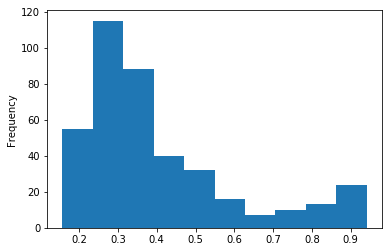

In [10]:
worker_res.prop_random.plot.hist()

In [11]:
indices_to_exclude

,round,batch,worker,mturk_id,disagree,neutral,agree,prop_random
13,1,1,5,A1P2RQ166VS5BT,0.244265,0.489481,0.266254,0.685695
19,1,2,3,A2PU5BM2YXFQQS,0.235364,0.309435,0.455201,0.825659
28,1,3,4,A1VR1XQEQQXYUE,0.153444,0.345825,0.500731,0.620384
35,1,4,3,A1K3SIFF770RB5,0.346948,0.361438,0.291614,0.889525
40,1,5,0,A29AKJXQ248KNK,0.260259,0.530716,0.209025,0.519023
...,...,...,...,...,...,...,...,...
379,5,7,3,AONRPFWPSEWX6,0.312181,0.191209,0.496610,0.941212
383,5,7,7,A2XW91EHCZ3T3V,0.236069,0.271547,0.492384,0.744748
385,5,8,1,A11M5KWP2835VO,0.366913,0.310235,0.322852,0.904175
386,5,8,2,A2YGOORS5N9RW8,0.151257,0.648289,0.200454,0.526170


In [12]:
full_ratings = pd.read_pickle('../MTurk/MTurk_results/full_ratings_per_round.pkl')

In [40]:
sources,types,texts,stances,MACEs,outlets = [],[],[],[],[],[]
for round_no in range(1,6):
    for batch_no in range(0,10):
        ratings = full_ratings[round_no][batch_no]
        # drop labels from low competence workers
        ratings = ratings.drop([c for c in ratings.columns[3:] 
                               if ratings[c]['MACE competence'] < 0.6], axis=1)
        for s_id in ratings.index[5:-1]:
            row = ratings.loc[s_id]
            for col in row.index[3:]:
                rating = row[col]
                sources.append('round{}_batch{}_sentid{}'.format(round_no,
                                                                batch_no,
                                                                s_id))
                types.append('mturk_flat')
                texts.append(row['sentence'])
                stances.append(rating)
                MACEs.append(row['MACE_pred'])
                outlets.append(get_orig_media_slant(int(round_no),int(batch_no),s_id))

In [41]:
flat_mturk_df = pd.DataFrame.from_dict({
    'source':sources,'type':types,'text':texts,'stance':stances,'MACE_pred':MACEs,'outlet':outlets
})

In [42]:
flat_mturk_df.to_pickle('./data/flat_mturk_df.pkl')
flat_mturk_df = pd.read_pickle('./data/flat_mturk_df.pkl')

In [ ]:
# need to divide portion into train, dev+test, stance of dev+test will be collapsed over 
# same source

In [60]:
#flat_mturk_df = labeled_data[labeled_data.type=='mturk_flat']

In [43]:
flat_mturk_df.head()

,source,type,text,stance,MACE_pred,outlet
0,round1_batch0_sentidt0,mturk_flat,"Warmer-than-normal sea surface temperatures are a key player in the development of hurricanes such as Katrina and superstorm Sandy, which hit the U.S. east coast in 2011.",neutral,agrees,0
1,round1_batch0_sentidt0,mturk_flat,"Warmer-than-normal sea surface temperatures are a key player in the development of hurricanes such as Katrina and superstorm Sandy, which hit the U.S. east coast in 2011.",neutral,agrees,0
2,round1_batch0_sentidt0,mturk_flat,"Warmer-than-normal sea surface temperatures are a key player in the development of hurricanes such as Katrina and superstorm Sandy, which hit the U.S. east coast in 2011.",neutral,agrees,0
3,round1_batch0_sentidt0,mturk_flat,"Warmer-than-normal sea surface temperatures are a key player in the development of hurricanes such as Katrina and superstorm Sandy, which hit the U.S. east coast in 2011.",agrees,agrees,0
4,round1_batch0_sentidt0,mturk_flat,"Warmer-than-normal sea surface temperatures are a key player in the development of hurricanes such as Katrina and superstorm Sandy, which hit the U.S. east coast in 2011.",agrees,agrees,0


In [27]:
# Get from shared train/dev/test split indices
dev_sources = set(dev_df.source.values)
test_sources = set(test_df.source.values)
eval_sources = dev_sources | test_sources

In [44]:
flat_dev_df = flat_mturk_df.loc[flat_mturk_df.source.isin(dev_sources)]
flat_test_df = flat_mturk_df.loc[flat_mturk_df.source.isin(test_sources)]
flat_train_df = flat_mturk_df.loc[~flat_mturk_df.source.isin(eval_sources)]
flat_train_df.shape,flat_dev_df.shape,flat_test_df.shape

((7422, 6), (663, 6), (1160, 6))

In [ ]:
# Need to collapse dev, test dfs and add 's' to 'agree','disagree'

In [65]:
# flat_dev_df['true_stance'] = [mturk_df.loc[mturk_df.source == row['source']].stance.values[0] 
#                               for ix,row in flat_dev_df.iterrows()]
flat_test_df['true_stance'] = [mturk_df.loc[mturk_df.source == row['source']].stance.values[0] 
                              for ix,row in flat_test_df.iterrows()]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [73]:
#flat_dev_df['true_stance'] = flat_dev_df['true_stance'].apply(lambda x: x+'s' if x[-1] == 'e' else x)
flat_test_df['true_stance'] = flat_test_df['true_stance'].apply(lambda x: x+'s' if x[-1] == 'e' else x)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [77]:
flat_dev_df_source_groups = flat_dev_df.groupby('source')
flat_test_df_source_groups = flat_test_df.groupby('source')

In [83]:
unflat_dev_df = flat_dev_df_source_groups.first()
unflat_test_df = flat_test_df_source_groups.first()
len(unflat_dev_df),len(unflat_test_df)

(140, 260)

In [55]:
labeled_data = labeled_data.append(flat_mturk_df,ignore_index=True)

In [56]:
labeled_data.shape

(687730, 4)

In [57]:
labeled_data.type.value_counts()

twint_tweet              520886
dallas_news_predicted    114686
dallas_news              40309 
mturk_flat               9245  
mturk                    2040  
semeval_train_tweets     395   
semeval_tweets           169   
Name: type, dtype: int64

In [59]:
labeled_data.to_pickle('labeled_data_df_2.pkl')

# Dallas ELMO predicted labeled news

In [59]:
import json
lines = []
with open('data/all-predicted-sentences.jsonlist') as f:
    for line in f:
        lines.append(json.loads(line))

In [61]:
len(lines)

114686

In [60]:
lines[:3]

[{'article_id': 'climate_change1.0-6365',
  'sent_index': 0,
  'tokens': ['No',
   'Accord',
   ',',
   'and',
   'Little',
   'Optimism',
   ',',
   'at',
   'Bonn',
   'Talks',
   'on',
   'Global',
   'Warming'],
  'primary_tone': 'Pro'},
 {'article_id': 'climate_change1.0-6365',
  'sent_index': 1,
  'tokens': ['Delegates',
   'from',
   '143',
   'countries',
   'ended',
   'their',
   'preliminary',
   'talks',
   'on',
   'global',
   'warming',
   'here',
   'today',
   'with',
   'no',
   'agreement',
   'on',
   'key',
   'issues',
   'and',
   'growing',
   'concern',
   'about',
   'the',
   'prospect',
   'for',
   'success',
   'at',
   'the',
   'concluding',
   'meeting',
   ',',
   'to',
   'be',
   'held',
   'in',
   'Kyoto',
   ',',
   'Japan',
   ',',
   'in',
   'early',
   'December',
   '.'],
  'primary_tone': 'Pro'},
 {'article_id': 'climate_change1.0-6365',
  'sent_index': 2,
  'tokens': ['The',
   'United',
   'States',
   "'",
   'long-awaited',
   'proposal'

In [62]:
Counter([line['primary_tone'] for line in lines])

Counter({'Pro': 113777, 'Anti': 909})

In [64]:
labeled_data = {'source':[],'type':[],'text':[],'stance':[]}
labeled_data['source'] = [l['article_id'] + ' [SEP] ' + str(l['sent_index']) 
                          for l in lines]
labeled_data['type'] = ['dallas_news_predicted']*len(lines)
labeled_data['text'] = [' '.join(l['tokens'])[:-2]+'.' for l in lines]
labeled_data['stance'] = [tone2label[l['primary_tone'].lower()] for l in lines]
labeled_data_df = pd.DataFrame(labeled_data)
labeled_data_df.head(10)

,source,type,text,stance
0,climate_change1.0-6365 [SEP] 0,dallas_news_predicted,"No Accord , and Little Optimism , at Bonn Talks on Global Warmi.",agree
1,climate_change1.0-6365 [SEP] 1,dallas_news_predicted,"Delegates from 143 countries ended their preliminary talks on global warming here today with no agreement on key issues and growing concern about the prospect for success at the concluding meeting , to be held in Kyoto , Japan , in early December.",agree
2,climate_change1.0-6365 [SEP] 2,dallas_news_predicted,The United States ' long-awaited proposal for cutting emissions of heat-trapping greenhouse gases has been scornfully attacked as too weak by delegates and environmentalists from around the world.,agree
3,climate_change1.0-6365 [SEP] 3,dallas_news_predicted,And there is no sign that American negotiators are about to yield.,agree
4,climate_change1.0-6365 [SEP] 4,dallas_news_predicted,"Still , the Americans themselves said there was more than a little cause for hope , and they have been lobbying their counterparts here , urging them to take a closer look at the American proposal.",agree
5,climate_change1.0-6365 [SEP] 5,dallas_news_predicted,"Meanwhile , several small-scale but higher-level meetings will be held between now and Dec. 1 , when the Kyoto conference begins.",agree
6,climate_change1.0-6365 [SEP] 6,dallas_news_predicted,"The goal of the conference is to revise the climate treaty negotiated in Rio in 1992 , which set voluntary limits on emissions.",agree
7,climate_change1.0-6365 [SEP] 7,dallas_news_predicted,"`` There are enough ideas out there to have an agreement , '' a senior State Department official said here , speaking on condition of anonymity.",agree
8,climate_change1.0-6365 [SEP] 8,dallas_news_predicted,`` We just do n't see all the kinds of coalescence that you need yet '' for that to happen.,agree
9,climate_change1.0-6365 [SEP] 9,dallas_news_predicted,"On the surface , the American proposal looks like the weakest on the table.",agree


In [70]:
labeled_data_df.shape

(114686, 4)

In [71]:
labeled_data = labeled_data.append(labeled_data_df, ignore_index = True)
labeled_data.to_csv('./tweet-stance-prediction/data/labeled_data_df')

# Dallas new labeled news

In [32]:
import json
lines = []
with open('data/all-annotated-sentences.jsonlist') as f:
    for line in f:
        lines.append(json.loads(line))

In [33]:
len(lines)

40790

In [34]:
lines[:5]

[{'article_id': 'climate_change1.0-12174',
  'sent_index': 0,
  'tokens': ['It',
   "'s",
   'about',
   'seeing',
   'the',
   'forest',
   'and',
   'the',
   'trees',
   'in',
   'Calif.',
   ';',
   'Scientists',
   'study',
   'global',
   'warming',
   "'s",
   'effect',
   'on',
   'redwoods',
   'and',
   'sequoias'],
  'primary_tone': 'Pro'},
 {'article_id': 'climate_change1.0-12174',
  'sent_index': 1,
  'tokens': ['Two',
   'of',
   'his',
   'colleagues',
   'dangled',
   'on',
   'ropes',
   '100',
   'feet',
   'above',
   'from',
   'the',
   'gnarled',
   'branches',
   'of',
   'a',
   'giant',
   'sequoia',
   'tree',
   '.'],
  'primary_tone': 'Pro'},
 {'article_id': 'climate_change1.0-12174',
  'sent_index': 2,
  'tokens': ['Steve',
   'Sillett',
   'could',
   'hardly',
   'contain',
   'his',
   'excitement',
   '.'],
  'primary_tone': 'Pro'},
 {'article_id': 'climate_change1.0-12174',
  'sent_index': 3,
  'tokens': ['``', 'This', 'site', 'is', 'just', 'juicy', '.

In [35]:
Counter([line['primary_tone'] for line in lines])

Counter({'Pro': 30917, 'Neutral': 3685, 'Anti': 6188})

In [40]:
tone2label = {'pro':'agree','anti':'disagree','neutral':'neutral'}

In [37]:
neutral_lines = [l for l in lines if l['primary_tone'] == 'Neutral']
len(neutral_lines)

3685

In [41]:
# Add all the neutrals to labeled_data_df
labeled_data = {'source':[],'type':[],'text':[],'stance':[]}
labeled_data['source'] = [l['article_id'] + ' [SEP] ' + str(l['sent_index']) 
                          for l in neutral_lines]
labeled_data['type'] = ['dallas_news']*len(neutral_lines)
labeled_data['text'] = [' '.join(l['tokens']) for l in neutral_lines]
labeled_data['stance'] = [tone2label[l['primary_tone'].lower()] for l in neutral_lines]
labeled_data_df = pd.DataFrame(labeled_data)
labeled_data_df.head(10)

,source,type,text,stance
0,climate_change1.0-9251 [SEP] 0,dallas_news,From Nuclear Freeze to Global Warming - and Back,neutral
1,climate_change1.0-9251 [SEP] 1,dallas_news,"In June 1982 , up to a million demonstrators gathered in Central Park calling for a nuclear freeze .",neutral
2,climate_change1.0-9251 [SEP] 2,dallas_news,"They were protesting the Reagan-era nuclear arms buildup and other developments they saw , not unreasonably , as a threat to civilization and to life on Earth , including talk by some Reagan aides about fighting and winning a nuclear war .",neutral
3,climate_change1.0-9251 [SEP] 3,dallas_news,"Last Sunday - a generation later - hundreds of thousands of demonstrators took part in the People 's Climate March in Manhattan to protest international inaction on global warming , which they see , not unreasonably , as a threat to civilization and to life on Earth.The front page of The New York Times on Monday brought the two events together , in an unintended though instructive way .",neutral
4,climate_change1.0-9251 [SEP] 4,dallas_news,The photographs were of the climate marchers .,neutral
5,climate_change1.0-9251 [SEP] 5,dallas_news,But the lead story was about the current aggressive efforts to rebuild the nation 's nuclear arsenal .,neutral
6,climate_change1.0-9251 [SEP] 6,dallas_news,"The fact that , 32 years after the Central Park gathering , progress on significant arms reductions is going into reverse is something the climate marchers should note .",neutral
7,climate_change1.0-9251 [SEP] 7,dallas_news,"Because , intentionally or not , the climate change movement mirrors the nuclear freeze in many ways .",neutral
8,climate_change1.0-9251 [SEP] 8,dallas_news,Both are rooted in the idea of a global planetary emergency .,neutral
9,climate_change1.0-9251 [SEP] 9,dallas_news,Both grew along with scientific evidence that challenges the status quo in politics and industry .,neutral


In [42]:
labeled_data_df.shape

(3685, 4)

In [47]:
labeled_data.shape

(39228, 5)

In [58]:
39228+3685

42913

In [53]:
labeled_data = labeled_data.append(labeled_data_df, ignore_index = True)
labeled_data.to_csv('./tweet-stance-prediction/data/labeled_data_df')

# Dallas labeled news

In [15]:
import json
lines = []
with open('data/all.pro-anti.sentences.jsonlist') as f:
    for line in f:
        lines.append(json.loads(line))

In [16]:
len(lines)

37105

In [22]:
lines[:5]

[{'article_id': 'climate_change1.0-12174',
  'sent_index': 0,
  'text': "It's about seeing the forest and the trees in Calif.; Scientists study global warming's effect on redwoods and sequoias",
  'tokens': ['It',
   "'s",
   'about',
   'seeing',
   'the',
   'forest',
   'and',
   'the',
   'trees',
   'in',
   'Calif.',
   ';',
   'Scientists',
   'study',
   'global',
   'warming',
   "'s",
   'effect',
   'on',
   'redwoods',
   'and',
   'sequoias'],
  'primary_tone': 'Pro'},
 {'article_id': 'climate_change1.0-12174',
  'sent_index': 1,
  'text': 'Two of his colleagues dangled on ropes 100 feet above from the gnarled branches of a giant sequoia tree.',
  'tokens': ['Two',
   'of',
   'his',
   'colleagues',
   'dangled',
   'on',
   'ropes',
   '100',
   'feet',
   'above',
   'from',
   'the',
   'gnarled',
   'branches',
   'of',
   'a',
   'giant',
   'sequoia',
   'tree',
   '.'],
  'primary_tone': 'Pro'},
 {'article_id': 'climate_change1.0-12174',
  'sent_index': 2,
  'text'

In [38]:
Counter([l['primary_tone'].lower() for l in lines])

Counter({'pro': 30917, 'anti': 6188})

In [39]:
tone2label = {'pro':'agree','anti':'disagree'}

In [58]:

labeled_data['source'] = [l['article_id'] + ' [SEP] ' + str(l['sent_index']) for l in lines]
labeled_data['type'] = ['dallas_news']*len(lines)
labeled_data['text'] = [l['text'] for l in lines]
labeled_data['stance'] = [tone2label[l['primary_tone'].lower()] for l in lines]
labeled_data_df = pd.DataFrame(labeled_data)
labeled_data_df.head(10)

,source,type,text,stance
0,climate_change1.0-12174 [SEP] 0,dallas_news,It's about seeing the forest and the trees in ...,agree
1,climate_change1.0-12174 [SEP] 1,dallas_news,Two of his colleagues dangled on ropes 100 fee...,agree
2,climate_change1.0-12174 [SEP] 2,dallas_news,Steve Sillett could hardly contain his excitem...,agree
3,climate_change1.0-12174 [SEP] 3,dallas_news,"""This site is just juicy.",agree
4,climate_change1.0-12174 [SEP] 4,dallas_news,"It's loaded,"" said Sillett, gazing up at the a...",agree
5,climate_change1.0-12174 [SEP] 5,dallas_news,"""There are amazing lichens up there.",agree
6,climate_change1.0-12174 [SEP] 6,dallas_news,There are aphids being hunted by ladybugs.,agree
7,climate_change1.0-12174 [SEP] 7,dallas_news,I found a sizable dogwood tree growing from a ...,agree
8,climate_change1.0-12174 [SEP] 8,dallas_news,"The foggy, lost worlds atop the world's bigges...",agree
9,climate_change1.0-12174 [SEP] 9,dallas_news,Concerned that rising temperatures across Cali...,agree


# Dallas unlabeled news

In [90]:
os.getcwd()

'/Users/yiweiluo/scientific-debates/cc_stance/data_creation'

In [92]:
import json
all_sents = []
with open('../data/all.sentences.jsonlist') as f:
    for line in f:
        all_sents.append(json.loads(line))

In [93]:
len(all_sents)

126100

In [94]:
len([line['primary_tone'] for line in all_sents if 'primary_tone' in line])

0

### Write to files for LM training

In [96]:
sentences = [x['text'] for x in all_sents]
len(sentences)

126100

In [99]:
train_ix,test_ix = train_test_split(list(range(len(sentences))),test_size=0.3)
len(train_ix),len(test_ix)

(88270, 37830)

In [101]:
train_sents = [sentences[ix] for ix in train_ix]
test_sents = [sentences[ix] for ix in test_ix]
len(train_sents),len(test_sents)

(88270, 37830)

In [102]:
train_sents[:3]

['The case argued before the court on Wednesday was filed in 2003 in Massachusetts by a coalition of 12 states, 13 environmental groups and three large cities, which believe the Earth is warming due to heat-trapping gases caused by human activity like automobile emissions.',
 'Obama clamps down on pollution Federal regulations are coming on gases from power plants.',
 'In the last 30 years, scientists have proposed a variety of ways to engineer the climate, most of them dismissed as too costly, too unpredictable, impossible or ineffective:']

In [103]:
with open('dallas.cc.train.raw','w+') as f:
    for s in train_sents:
        f.write(s)
        f.write(' ')
with open('dallas.cc.test.raw','w+') as f:
    for s in test_sents:
        f.write(s)
        f.write(' ')

In [104]:
with open('../LM_data/both.cc.fulltexts.uncased.train.raw','a') as f:
    for s in train_sents:
        f.write(s.lower())
        f.write(' ')
with open('../LM_data/both.cc.fulltexts.uncased.test.raw','a') as f:
    for s in test_sents:
        f.write(s.lower())
        f.write(' ')

In [20]:
'climate_change1.0-6365 [SEP] 0' in labeled_data_df['source']

False

In [84]:
#all_sents[1]

In [178]:
unlabeled_data['source'] = [l['article_id'] + ' [SEP] ' + str(l['sent_index']) 
                               for l in all_sents]
unlabeled_data['type'] = ['dallas_news']*len(all_sents)
unlabeled_data['text'] = [l['text'] for l in all_sents]
unlabeled_data_df = pd.DataFrame(unlabeled_data)
unlabeled_data_df.head(10)

,source,type,text
0,climate_change1.0-6365 [SEP] 0,dallas_news,"No Accord, and Little Optimism, at Bonn Talks ..."
1,climate_change1.0-6365 [SEP] 1,dallas_news,Delegates from 143 countries ended their preli...
2,climate_change1.0-6365 [SEP] 2,dallas_news,The United States' long-awaited proposal for c...
3,climate_change1.0-6365 [SEP] 3,dallas_news,And there is no sign that American negotiators...
4,climate_change1.0-6365 [SEP] 4,dallas_news,"Still, the Americans themselves said there was..."
5,climate_change1.0-6365 [SEP] 5,dallas_news,"Meanwhile, several small-scale but higher-leve..."
6,climate_change1.0-6365 [SEP] 6,dallas_news,The goal of the conference is to revise the cl...
7,climate_change1.0-6365 [SEP] 7,dallas_news,"""There are enough ideas out there to have an a..."
8,climate_change1.0-6365 [SEP] 8,dallas_news,"""We just don't see all the kinds of coalescenc..."
9,climate_change1.0-6365 [SEP] 9,dallas_news,"On the surface, the American proposal looks li..."


# SemEval tweets

In [4]:
targets = []
with open(os.getcwd()+'/data/semeval2016-task6-testdata-gold/SemEval2016-Task6-subtaskB-testdata\
-gold.txt') as f:
    semeval_b = f.readlines()
    for line in semeval_b[1:]:
        id_,target,tweet,stance = line.strip().split('\t')
        targets.append(target)

In [5]:
from collections import Counter
Counter(targets)

Counter({'Donald Trump': 707})

In [6]:
semeval_tweets = []
with open(os.getcwd()+'/data/semeval2016-task6-testdata-gold/SemEval2016-Task6-subtaskA-testdata\
-gold.txt') as f:
    semeval_a = f.readlines()
    for line in semeval_a[1:]:
        id_,target,tweet,stance = line.strip().split('\t')
        if target == 'Climate Change is a Real Concern':
            semeval_tweets.append(line.strip().split('\t'))

In [7]:
len(semeval_tweets)

169

In [8]:
from collections import Counter
Counter([x[-1] for x in semeval_tweets])

Counter({'NONE': 35, 'FAVOR': 123, 'AGAINST': 11})

In [9]:
tweetstance2label = {'NONE':'neutral','FAVOR':'agree','AGAINST':'disagree'}

In [11]:
labeled_data['source'].extend([l[0] for l in semeval_tweets])
labeled_data['type'].extend(['semeval_tweets']*len(semeval_tweets))
labeled_data['text'].extend([l[2] for l in semeval_tweets])
labeled_data['stance'].extend([tweetstance2label[l[3]] for l in semeval_tweets])
labeled_data_df = pd.DataFrame(labeled_data)
labeled_data_df.head(10)

,source,type,text,stance
0,10221,semeval_tweets,Closed door session begins. More after they de...,neutral
1,10222,semeval_tweets,What is the #energiewende agenda? Why are they...,agree
2,10223,semeval_tweets,@climasphere Stocker: Fish catch potential cou...,agree
3,10224,semeval_tweets,"...a longer memory, and a sterner sense of jus...",neutral
4,10225,semeval_tweets,"Boni ""Future Sea level rise will not be unifor...",agree
5,10226,semeval_tweets,@climasphere Bony: Extreme weather events (hea...,agree
6,10227,semeval_tweets,Camille Parmesan: 2/3 of species have changed ...,agree
7,10228,semeval_tweets,5 meta-analyses show 1/2 of species have chang...,agree
8,10229,semeval_tweets,It literarly just took me 10 minutes to get in...,neutral
9,10230,semeval_tweets,Grubb: state of energy: shift US & EU from net...,agree


In [12]:
semeval_tweets

[['10221',
  'Climate Change is a Real Concern',
  'Closed door session begins. More after they decide on the entities.  #GCF #SemST',
  'NONE'],
 ['10222',
  'Climate Change is a Real Concern',
  'What is the #energiewende agenda? Why are they not in the "de-carbonizer" camp?.  How long will you tolerate the lies?  #SemST',
  'FAVOR'],
 ['10223',
  'Climate Change is a Real Concern',
  '@climasphere Stocker: Fish catch potential could drop by as much as 50% in some areas due to #oceanacidification. #CFCC15 #SemST',
  'FAVOR'],
 ['10224',
  'Climate Change is a Real Concern',
  '...a longer memory, and a sterner sense of justice than we do. -W.Berry #SemST',
  'NONE'],
 ['10225',
  'Climate Change is a Real Concern',
  'Boni "Future Sea level rise will not be uniform & different for coasts" #CCFC15 #Journey2015 #SemST',
  'FAVOR'],
 ['10226',
  'Climate Change is a Real Concern',
  '@climasphere Bony: Extreme weather events (heat waves, drought, flooding, windstorms) made more frequent

In [43]:
labeled_data_df.tail(10)

,source,type,text,stance
37264,10380,semeval_tweets,@4EvaMartino Everyone should learn this recip...,agree
37265,10381,semeval_tweets,Rec high temp for this date in Charlotte is 10...,agree
37266,10382,semeval_tweets,"Lot's of time, class over! @nationaljournal #S...",neutral
37267,10383,semeval_tweets,@TheLibertyEagle Oh for the love of Pete! I th...,neutral
37268,10384,semeval_tweets,If complaining about irrelevant problems were ...,neutral
37269,10385,semeval_tweets,"@LiberalAus - ""All"" you folks #owe me an #offi...",neutral
37270,10386,semeval_tweets,"Maybe we should start ""labelling every #produc...",agree
37271,10387,semeval_tweets,If we touch #Antarctica for one more #reason o...,agree
37272,10388,semeval_tweets,Wind power helped stabilize Texas' power grid ...,agree
37273,10389,semeval_tweets,"It's so cold and windy here in Sydney, I just ...",agree


In [13]:
stance_test = pd.read_csv(open(os.getcwd()+'/data/StanceDataset/test.csv','rU'),
                          encoding='utf-8', engine='c')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 'U' mode is deprecated
  """Entry point for launching an IPython kernel.


In [14]:
stance_test = stance_test[stance_test['Target'] == 'Climate Change is a Real Concern']

In [15]:
stance_test.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
220,Closed door session begins. More after they de...,Climate Change is a Real Concern,NONE,3. The tweet is not explicitly expressing opi...,other
221,What is the #energiewende agenda? Why are they...,Climate Change is a Real Concern,FAVOR,1. The tweet explicitly expresses opinion abo...,neg
222,@climasphere Stocker: Fish catch potential cou...,Climate Change is a Real Concern,FAVOR,1. The tweet explicitly expresses opinion abo...,neg
223,"...a longer memory, and a sterner sense of jus...",Climate Change is a Real Concern,NONE,2. The tweet does NOT expresses opinion about ...,other
224,"Boni ""Future Sea level rise will not be unifor...",Climate Change is a Real Concern,FAVOR,1. The tweet explicitly expresses opinion abo...,other


In [16]:
labeled_data['source'].extend(list(stance_test.index))
labeled_data['type'].extend(['semeval_test_tweets']*len(stance_test))
labeled_data['text'].extend([stance_test.loc[l]['Tweet'] for l in stance_test.index])
labeled_data['stance'].extend([tweetstance2label[stance_test.loc[l]['Stance']] 
                               for l in stance_test.index])
labeled_data_df = pd.DataFrame(labeled_data)
labeled_data_df.head(10)

,source,type,text,stance
0,10221,semeval_tweets,Closed door session begins. More after they de...,neutral
1,10222,semeval_tweets,What is the #energiewende agenda? Why are they...,agree
2,10223,semeval_tweets,@climasphere Stocker: Fish catch potential cou...,agree
3,10224,semeval_tweets,"...a longer memory, and a sterner sense of jus...",neutral
4,10225,semeval_tweets,"Boni ""Future Sea level rise will not be unifor...",agree
5,10226,semeval_tweets,@climasphere Bony: Extreme weather events (hea...,agree
6,10227,semeval_tweets,Camille Parmesan: 2/3 of species have changed ...,agree
7,10228,semeval_tweets,5 meta-analyses show 1/2 of species have chang...,agree
8,10229,semeval_tweets,It literarly just took me 10 minutes to get in...,neutral
9,10230,semeval_tweets,Grubb: state of energy: shift US & EU from net...,agree


In [61]:
labeled_data_df.tail(10)

,source,type,text,stance
37433,379,semeval_test_tweets,@4EvaMartino Everyone should learn this recip...,agree
37434,380,semeval_test_tweets,Rec high temp for this date in Charlotte is 10...,agree
37435,381,semeval_test_tweets,"Lot's of time, class over! @nationaljournal #S...",neutral
37436,382,semeval_test_tweets,@TheLibertyEagle Oh for the love of Pete! I th...,neutral
37437,383,semeval_test_tweets,If complaining about irrelevant problems were ...,neutral
37438,384,semeval_test_tweets,"@LiberalAus - ""All"" you folks #owe me an #offi...",neutral
37439,385,semeval_test_tweets,"Maybe we should start ""labelling every #produc...",agree
37440,386,semeval_test_tweets,If we touch #Antarctica for one more #reason o...,agree
37441,387,semeval_test_tweets,Wind power helped stabilize Texas' power grid ...,agree
37442,388,semeval_test_tweets,"It's so cold and windy here in Sydney, I just ...",agree


In [18]:
stance_train = pd.read_csv(open(os.getcwd()+'/data/StanceDataset/train.csv','rU'),
                          encoding='utf-8', engine='c')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 'U' mode is deprecated
  """Entry point for launching an IPython kernel.


In [19]:
stance_train = stance_train[stance_train['Target'] == 'Climate Change is a Real Concern']

In [20]:
stance_train.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
613,"We cant deny it, its really happening. #SemST",Climate Change is a Real Concern,FAVOR,1. The tweet explicitly expresses opinion abo...,other
614,RT @cderworiz: Timelines are short. Strategy m...,Climate Change is a Real Concern,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
615,SO EXCITING! Meaningful climate change action ...,Climate Change is a Real Concern,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
616,"Delivering good jobs for Albertans, maintainin...",Climate Change is a Real Concern,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
617,@davidswann says he wants carbon fund to be sp...,Climate Change is a Real Concern,FAVOR,3. The tweet is not explicitly expressing opi...,other


In [24]:
labeled_data['source'].extend(list(stance_train.index))
labeled_data['type'].extend(['semeval_train_tweets']*len(stance_train))
labeled_data['text'].extend([stance_train.loc[l]['Tweet'] for l in stance_train.index])
labeled_data['stance'].extend([tweetstance2label[stance_train.loc[l]['Stance']] 
                               for l in stance_train.index])
labeled_data_df = pd.DataFrame(labeled_data)
labeled_data_df.head(10)

,source,type,text,stance
0,10221,semeval_tweets,Closed door session begins. More after they decide on the entities. #GCF #SemST,neutral
1,10222,semeval_tweets,"What is the #energiewende agenda? Why are they not in the ""de-carbonizer"" camp?. How long will you tolerate the lies? #SemST",agree
2,10223,semeval_tweets,@climasphere Stocker: Fish catch potential could drop by as much as 50% in some areas due to #oceanacidification. #CFCC15 #SemST,agree
3,10224,semeval_tweets,"...a longer memory, and a sterner sense of justice than we do. -W.Berry #SemST",neutral
4,10225,semeval_tweets,"Boni ""Future Sea level rise will not be uniform & different for coasts"" #CCFC15 #Journey2015 #SemST",agree
5,10226,semeval_tweets,"@climasphere Bony: Extreme weather events (heat waves, drought, flooding, windstorms) made more frequent/intense by #CFCC15 #SemST",agree
6,10227,semeval_tweets,Camille Parmesan: 2/3 of species have changed #habitat because of #H12 #CFCC15 #SemST,agree
7,10228,semeval_tweets,"5 meta-analyses show 1/2 of species have changed where they live, 2/3 have changed when they live. Camille Parmesan #CFCC15 #SemST",agree
8,10229,semeval_tweets,It literarly just took me 10 minutes to get in a bus because an old lady just had to go in front of everyone... #SemST,neutral
9,10230,semeval_tweets,"Grubb: state of energy: shift US & EU from net-producer to net-importer of emissions"" #CCFC15 #journey2015 #SemST",agree


In [26]:
labeled_data_df[labeled_data_df.stance=='disagree']

,source,type,text,stance
99,10320,semeval_tweets,ONE Volcano emits more pollution than man has in our HISTORY! #SemST,disagree
109,10330,semeval_tweets,@UN ice cracking in the summer?? SO ALARMING. #climatechangehoax #SemST,disagree
120,10341,semeval_tweets,"#ClimateChangeDefinitions ""settled science"" = flawed computer models with jiggered data to force a predefined conclusion. #SemST",disagree
127,10348,semeval_tweets,@Myrmecos Still a larval theory. Still poorly modelled. Still unquantified. Still multi-factor. Still flummoxed by albedo. #SemST,disagree
136,10357,semeval_tweets,Climate deniers is a term used to silence those pointing out the hypocrisy in the fanatical zeal on #climatetruth #SemST,disagree
145,10366,semeval_tweets,"@wattsupwiththat yes ironic that the alarmists are the actual ""deniers #SemST",disagree
146,10367,semeval_tweets,@JustinTrudeau Hey Justin I will give you 50 cents if you stop talking about climate 'Change' #Ottawa #davidsuzuki #cbc #SemST,disagree
147,10368,semeval_tweets,If @EPA & @POTUS don't have to follow SCOTUS why should anyone else have to #ClimateFraud #SpecialReport #WakeUpAmerica #SemST,disagree
149,10370,semeval_tweets,"Govt announcement on zero carbon homes ""short-sighted, unnecessary, retrograde and damaging"" says @UKGBC #energyefficiency #SemST",disagree
151,10372,semeval_tweets,"We are not ""killing the Earth"". The Earth has been through worse and will be fine after all humans suffocate, drown or starve #SemST",disagree


# Dallas and Yiwei manually annotated news--not yet added

In [28]:
import json
dallas_labels = []
with open('subsample_annotated_dbc.jsonlist') as f:
    for line in f:
        dallas_labels.append(json.loads(line))

In [29]:
len(dallas_labels)

300

In [34]:
dallas_labels[10:20]

[{'comp_clause': "that measures such as conservation wo n't cost much and will buy insurance against global warming",
  'full': "Some argue that measures such as conservation won't cost much and will buy insurance against global warming.",
  'key': 106901,
  'label': 0},
 {'comp_clause': 'I became somewhat inspired',
  'full': '"I became somewhat inspired," he said.',
  'key': 143590,
  'label': 3},
 {'comp_clause': 'if he ’s joking',
  'full': '“I would argue, as would many other beeologists,” he says, “that most bees are arguably cuter than most kids.” It’s hard to tell if he’s joking.',
  'key': 61472,
  'label': 3},
 {'comp_clause': 'the Earth habitable',
  'full': 'Gases such as carbon dioxide trap the energy that pours down on the Earth from the sun, making the Earth habitable.',
  'key': 276801,
  'label': 2},
 {'comp_clause': 'Rescue workers tried to \xa0 expand the sweater idea to pelicans \xa0 during the Gulf spill in 2010',
  'full': 'Rescue workers tried to\xa0expand the sw

In [31]:
yiwei_labels = pd.read_csv('subsample_annotated_yiwei.csv',header=None)

In [32]:
yiwei_labels.head()

,0,1,2,3
0,19565,"Reading ""an early draft"" of a federal government report has helped David Ignatius see that the global warming debate is just like the tobacco wars of the past four decades [""Naysay Now, Pay Later,"" op-ed, Aug. 18].",that the global warming debate is just like the tobacco wars of the past four decades,1
1,92670,"We haven’t seen that in the observations,” Myles Allen, professor of geosystem science at the University of Oxford and one of the study’s authors, told the Times of London, as reported in The Independent.","that in the observations , ” Myles Allen , professor of geosystem science at the University of Oxford and one of the study ’s authors , told the Times of London , as reported in The Independent",2
2,152040,"Describing it as a rare hybrid “superstorm,” forecasters say Sandy was created by an Arctic jet stream wrapping itself around a tropical storm.",Sandy was created by an Arctic jet stream wrapping itself around a tropical storm,2
3,191315,JEFFERSON CITY o Ameren Missouri says it must decide quickly on how to comply with proposed Environmental Protection Agency rules limiting carbon pollution.,it must decide quickly on how to comply with proposed Environmental Protection Agency rules limiting carbon pollution,2
4,250921,"There was this exposé in the Times where you first were talking to Andrew Revkin and explaining what was happening under the Bush administration, and even before that, the suppression of your work when you testified before Congress to, what, Senator Al Gore at the time.","what was happening under the Bush administration ,",3


In [75]:
anti_test_data = []
pro_test_data = []
with open(os.getcwd()+'/test_data/anti-cc/test_data.txt') as f:
    for line in f:
        anti_test_data.append(line.split('\t'))
with open(os.getcwd()+'/test_data/pro-cc/test_data.txt') as f:
    for line in f:
        pro_test_data.append(line.split('\t'))

In [76]:
len(anti_test_data)

92804

In [77]:
anti_test_data[0]

['We ’re also doing some avian and marine mammal monitoring',
 '',
 'sent_no_29 of https://www.csmonitor.com/Environment/2010/1012/Will-Google-wind-power-project-harm-wildlife-Depends-on-location.',
 '',
 '“We’re also doing some avian and marine mammal monitoring,” says Rhonda Jackson, a spokesman for Fishermen’s Energy.\n']

In [78]:
len(pro_test_data)

581383

In [81]:
Counter([len(d) for d in pro_test_data])

Counter({5: 286327,
         1: 290241,
         17: 2316,
         6: 113,
         7: 59,
         9: 34,
         29: 2,
         14: 27,
         11: 33,
         8: 12,
         15: 1,
         53: 353,
         273: 56,
         292: 1,
         111: 91,
         106: 464,
         138: 459,
         271: 165,
         103: 209,
         145: 1,
         107: 12,
         60: 5,
         75: 11,
         54: 7,
         68: 6,
         132: 2,
         94: 2,
         128: 5,
         348: 17,
         95: 1,
         57: 1,
         283: 1,
         71: 11,
         354: 13,
         360: 1,
         380: 2,
         401: 1,
         74: 1,
         129: 2,
         69: 17,
         369: 2,
         414: 1,
         70: 4,
         77: 2,
         318: 4,
         117: 14,
         91: 7,
         139: 5,
         121: 8,
         130: 3,
         358: 5,
         362: 2,
         287: 1,
         169: 7,
         186: 4,
         203: 4,
         277: 6,
         382: 5,
      

# Yiwei unlabeled news

In [98]:
all_url_df = pd.read_pickle('/Users/yiweiluo/Dropbox/research/\
QP2/code/Fox_and_friends/all_urls_meta_and_fulltext_df_2020.pkl')

In [99]:
cc_all_url_df = all_url_df[all_url_df['topic'] == 'cc'][all_url_df['bad NYT'] == False]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [100]:
cc_all_url_df.head()

,bad NYT,date,domain,fulltext,stance,title,topic,url
1600,False,None,:///,If you can't sleep as much as you need durin...,anti,None,cc,foxnews.com/lifestyle/climate-change-might-be-...
1601,False,None,:///,Paper says draft document by scientists direct...,anti,None,cc,foxnews.com/opinion/climate-policy-get-ready-f...
1602,False,None,:///,The public's concern about global warming has ...,anti,None,cc,foxnews.com/opinion/physicist-dont-fall-for-th...
1603,False,None,:///,The federal report by dozens of U.S. governmen...,anti,None,cc,foxnews.com/politics/junk-science-studies-behi...
1604,False,None,:///,File photo - A statue of the Virgin Mary is ...,anti,None,cc,foxnews.com/science/10-years-after-hurricane-k...


In [102]:
cc_all_url_df.shape

(17601, 8)

In [181]:
from nltk.tokenize import sent_tokenize
for ix,row in cc_all_url_df.iterrows():
    source = row['url']
    type_ = 'yiwei_news'
    if row['fulltext'] is not None:
        text = sent_tokenize(row['fulltext'])
        unlabeled_data['text'].extend(text)
        unlabeled_data['type'].extend([type_]*len(text))
        unlabeled_data['source'].extend([source]*len(text))

In [192]:
unlabeled_data_df = pd.DataFrame(unlabeled_data)
unlabeled_data_df.head(10)

,source,type,text
0,climate_change1.0-6365 [SEP] 0,dallas_news,"No Accord, and Little Optimism, at Bonn Talks ..."
1,climate_change1.0-6365 [SEP] 1,dallas_news,Delegates from 143 countries ended their preli...
2,climate_change1.0-6365 [SEP] 2,dallas_news,The United States' long-awaited proposal for c...
3,climate_change1.0-6365 [SEP] 3,dallas_news,And there is no sign that American negotiators...
4,climate_change1.0-6365 [SEP] 4,dallas_news,"Still, the Americans themselves said there was..."
5,climate_change1.0-6365 [SEP] 5,dallas_news,"Meanwhile, several small-scale but higher-leve..."
6,climate_change1.0-6365 [SEP] 6,dallas_news,The goal of the conference is to revise the cl...
7,climate_change1.0-6365 [SEP] 7,dallas_news,"""There are enough ideas out there to have an a..."
8,climate_change1.0-6365 [SEP] 8,dallas_news,"""We just don't see all the kinds of coalescenc..."
9,climate_change1.0-6365 [SEP] 9,dallas_news,"On the surface, the American proposal looks li..."


In [193]:
unlabeled_data_df.tail(10)

,source,type,text
1158101,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,"and ""do you have a signed ration card from you..."
1158102,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,You can stand by but there's no telling when a...
1158103,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,Comrade.
1158104,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,"Now, a really good high-speed rail system woul..."
1158105,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,Let's say something that can travel at 500 mil...
1158106,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,"Something that can go to every major city, and..."
1158107,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,"Something that doesn't need new rights of way,..."
1158108,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,Something where the rights of way are as free ...
1158109,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,But hoping for something like that is just cra...
1158110,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,https://pjmedia.com/trending/aoc-and-the-magic...


# Clean, dedup, filter labeled and unlabeled data

In [110]:
# Functions for importing & cleaning labeled items
def lower(s):
    return s.lower()

def imports(filename):
    imp = pd.read_pickle(filename)
    imp = imp.drop_duplicates()
    imp['sent_clean'] = imp['sentence'].str.replace('http\S+|www.\S+|pic.twitter.com\S+', '', case=False)
    #imp['sent_clean'] = imp['sentence'].replace('[^A-Za-z0-9 ]+','',regex=True)
    imp['sent_clean'] = imp['sent_clean'].apply(lower)
    return imp

def clean(x):
    return x.replace('http\S+|www.\S+|pic.twitter.com\S+', '')

In [194]:
unlabeled_data_df = unlabeled_data_df.dropna()
unlabeled_data_df['text'] = unlabeled_data_df['text'].apply(clean)
unlabeled_data_df.drop_duplicates(subset= 'text',inplace=True)
unlabeled_data_df = unlabeled_data_df.reset_index()

In [195]:
labeled_data_df = labeled_data_df.dropna()
labeled_data_df['text'] = labeled_data_df['text'].apply(clean)
labeled_data_df.drop_duplicates(subset= 'text',inplace=True)
labeled_data_df = labeled_data_df.reset_index()

In [196]:
labeled_data_df = labeled_data_df.drop(['index'],axis=1)

In [197]:
unlabeled_data_df.shape

(866654, 4)

In [198]:
labeled_data_df.shape

(39228, 4)

In [ ]:
# summary of what's included

# Create MTurk train/eval splits for IAA comparisons

In [34]:
full_annotator_ratings = pickle.load(open('../MTurk/MTurk_results/full_ratings_per_round.pkl','rb'))
full_annotator_ratings.keys()

dict_keys([1, 2, 3, 4, 5])

In [35]:
def get_annotator_ratings(r,b,sent_id):
    df_ = full_annotator_ratings[int(r)][int(b)]
#     ratings = df_.loc['t'+sent_id][['worker_{}'.format(w_id) for w_id in range(0,8) 
#                 if df_.loc['MACE competence']['worker_{}'.format(w_id)] > 0.5]].values
    ratings = df_.loc[sent_id][['worker_{}'.format(w_id) for w_id in range(0,8)]].values
    
    return ratings

In [56]:
r_no = 5
for b_no in range(0,10):
    srcs_for_eval = set(['round{}_batch{}_sentid{}'.format(r_no,b_no,s_id) for s_id in 
                   pd.DataFrame(full_annotator_ratings[r_no][b_no]).index.values[:-1]])
    dev_df = mturk_df.loc[mturk_df.source.isin(srcs_for_eval)]
    train_df = mturk_df.loc[~mturk_df.source.isin(srcs_for_eval)]
    print(len(dev_df),len(train_df))
    assert len(set(dev_df.source.values).intersection(set(train_df.source.values))) == 0
    
    data_type = 'mturk_round{}_batch{}'.format(r_no,b_no) 

    SAVE_DIR = './scripts/save/{}/'.format(data_type)
    print(SAVE_DIR)
    if not os.path.exists(SAVE_DIR):
        os.mkdir(SAVE_DIR)

    if train_df is not None:
        print(train_df.shape) 
        
    train_df_by_stance = {s: train_df.loc[train_df.stance == s] for s in stances} if train_df is not None else None
    dev_df_by_stance = {s: dev_df.loc[dev_df.stance == s] for s in stances}

    train_X_by_stance = {s: train_df_by_stance[s].text.values for i,s in enumerate(stances)} if train_df is not None else None
    dev_X_by_stance = {s: dev_df_by_stance[s].text.values for i,s in enumerate(stances)}

    train_Y_by_stance = {s: np.array([class_nums[x] for x in train_df_by_stance[s].stance]) for i,s in enumerate(stances)} if train_df is not None else None
    dev_Y_by_stance = {s: np.array([class_nums[x] for x in dev_df_by_stance[s].stance]) for i,s in enumerate(stances)}

    if train_df is not None:
        trX = []
        trY = []
        for i,s in enumerate(stances):
            for t, y in zip(train_X_by_stance[s], train_Y_by_stance[s]):
                trX.append(t)
                trY.append(y)

    vaX = []
    vaY = []
    for i,s in enumerate(stances):
        for t, y in zip(dev_X_by_stance[s], dev_Y_by_stance[s]):
            vaX.append(t)
            vaY.append(y)

    train_dat = pd.DataFrame({'sentence':trX,'stance':trY}) if train_df is not None else None
    val_dat = pd.DataFrame({'sentence':vaX,'stance':vaY})
    if train_df is not None:
        print('Train distribution:')
        print(train_dat.stance.value_counts()) 
    print('\nDev distribution:')
    print(val_dat.stance.value_counts())

    if train_df is not None:
        train_dat.to_csv(SAVE_DIR+'train.tsv',sep='\t',header=None,index=False)
    val_dat.to_csv(SAVE_DIR+'dev.tsv',sep='\t',header=None,index=False)

50 2000
./scripts/save/mturk_round5_batch0/
(2000, 4)
Train distribution:
1    846
0    764
2    390
Name: stance, dtype: int64

Dev distribution:
0    19
1    17
2    14
Name: stance, dtype: int64
50 2000
./scripts/save/mturk_round5_batch1/
(2000, 4)
Train distribution:
1    843
0    764
2    393
Name: stance, dtype: int64

Dev distribution:
1    20
0    19
2    11
Name: stance, dtype: int64
50 2000
./scripts/save/mturk_round5_batch2/
(2000, 4)
Train distribution:
1    844
0    760
2    396
Name: stance, dtype: int64

Dev distribution:
0    23
1    19
2    8 
Name: stance, dtype: int64
50 2000
./scripts/save/mturk_round5_batch3/
(2000, 4)
Train distribution:
1    847
0    764
2    389
Name: stance, dtype: int64

Dev distribution:
0    19
1    16
2    15
Name: stance, dtype: int64
50 2000
./scripts/save/mturk_round5_batch4/
(2000, 4)
Train distribution:
1    843
0    763
2    394
Name: stance, dtype: int64

Dev distribution:
1    20
0    20
2    10
Name: stance, dtype: int64
50 2000
./

# Create train / val / test splits for each train data type

## Add original outlet slant as feature

In [36]:
data_for_mturk_old = pickle.load(open('/Users/yiweiluo/Dropbox/research/QP2/code/Fox_and_friends/data_for_mturk.pkl',
                                     'rb'))
data_for_mturk = pickle.load(open('/Users/yiweiluo/Dropbox/research/QP2/code/Fox_and_friends/data_for_mturk_2020.pkl',
                                 'rb'))

In [67]:
set(data_for_mturk.sent_key.values).intersection(set(data_for_mturk_old.sent_key.values))

set()

In [74]:
data_for_mturk.shape

(3510, 7)

In [75]:
data_for_mturk.index

RangeIndex(start=0, stop=3510, step=1)

In [38]:
ROUND_DATA = {i: pickle.load(open('/Users/yiweiluo/Dropbox/research/QP2/code/Fox_and_friends/\
LIVE_ROUND{}_BATCH_DATA.pkl'.format(i),'rb')) for i in [n+1 for n in range(0,5)]}

In [34]:
def get_orig_media_slant(r_no,b_no,s_id):
    if r_no < 5:
        df_ = data_for_mturk_old
    else:
        df_ = data_for_mturk
    
    b_df_ = pd.DataFrame(ROUND_DATA[r_no][b_no])
    df_key = b_df_.loc[b_df_.sent_id == s_id].df_key.values[0]
    
    def str_to_int(s):
        return int(s == 'pro') # 1 for pro, 0 for anti
        
    return str_to_int(df_.iloc[df_key].bias)

## All SemEval tweets as eval

In [109]:
semeval_df = labeled_data.loc[labeled_data.type.isin({'semeval_tweets','semeval_train_tweets'})]
semeval_df.shape

(564, 4)

In [118]:
true_test_df = labeled_data.loc[labeled_data.type == 'semeval_tweets']
true_test_df.shape

(169, 4)

In [119]:
SAVE_DIR

'./scripts/save/semeval/'

In [122]:
test_df_by_stance = {s: true_test_df.loc[true_test_df.stance == s] for s in stances}
test_X_by_stance = {s: test_df_by_stance[s].text.values for i,s in enumerate(stances)}
test_Y_by_stance = {s: np.array([class_nums[x] for x in test_df_by_stance[s].stance]) for i,s in enumerate(stances)}

teX = []
teY = []
for i,s in enumerate(stances):
    for t, y in zip(test_X_by_stance[s], test_Y_by_stance[s]):
        teX.append(t)
        teY.append(y)

test_dat = pd.DataFrame({'sentence':teX,'stance':teY})
print('\nTrue test distribution:')
print(test_dat.stance.value_counts())

test_dat.to_csv(SAVE_DIR+'true_test.tsv',sep='\t',header=None,index=False)


True test distribution:
0    123
1    35 
2    11 
Name: stance, dtype: int64


In [110]:
eval_ix = semeval_df.index.values
dev_ix,test_ix = train_test_split(eval_ix,test_size=0.65)
len(dev_ix),len(test_ix)

(197, 367)

In [111]:
dev_df = semeval_df.loc[dev_ix]
test_df = semeval_df.loc[test_ix]
dev_df.shape,test_df.shape

((197, 4), (367, 4))

## Single, shared dev + test set (from labeled MTurk)

In [16]:
mturk_df = labeled_data.loc[labeled_data.type=='mturk']
mturk_df.shape

(2050, 4)

In [100]:
df_outlets = []
for src in mturk_df.source.values:
    spl = src.split('_')
    r_ = spl[0][-1]
    b_ = spl[1][-1]
    sid_ = spl[-1][6:]
    outlet = get_orig_media_slant(int(r_),int(b_),sid_)
    df_outlets.append(outlet)
mturk_df['outlet'] = df_outlets
mturk_df.shape

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


(2050, 5)

In [102]:
mturk_df.outlet.value_counts()

0    1041
1    1009
Name: outlet, dtype: int64

In [118]:
1041/2050

0.5078048780487805

In [113]:
mturk_df_outlet_groups = mturk_df.groupby('outlet')

In [125]:
# Right-wing
mturk_df_outlet_groups.get_group(1).stance.value_counts()

agree       468
neutral     426
disagree    115
Name: stance, dtype: int64

In [117]:
# Left-wing
mturk_df_outlet_groups.get_group(0).stance.value_counts()

neutral     437
agree       315
disagree    289
Name: stance, dtype: int64

In [17]:
_,eval_ix = train_test_split(mturk_df.index.values,test_size=400)
dev_ix,test_ix = train_test_split(eval_ix,test_size=0.65)
len(dev_ix),len(test_ix)

(140, 260)

In [18]:
dev_df = mturk_df.loc[dev_ix]
test_df = mturk_df.loc[test_ix]
dev_df.shape,test_df.shape

((140, 4), (260, 4))

In [19]:
dev_df.source

677553    round4_batch0_sentidt8 
677131    round2_batch9_sentidt26
678145    round5_batch3_sentidt0 
677075    round2_batch8_sentidt10
678245    round5_batch5_sentidt0 
                   ...           
677417    round3_batch6_sentidt32
676643    round1_batch6_sentidt25
676557    round1_batch3_sentidt29
677128    round2_batch9_sentidt23
678073    round5_batch1_sentidt28
Name: source, Length: 140, dtype: object

In [106]:
mturk_df.index.values

array([676445, 676446, 676447, ..., 678492, 678493, 678494])

## Vanilla MTurk

In [108]:
vanilla_train_df = mturk_df.loc[~mturk_df.index.isin(eval_ix)]
vanilla_train_df.shape # Expect it to be 2050-400 = 1650

(1650, 5)

In [109]:
vanilla_train_df

,source,type,text,stance,outlet
676445,round1_batch0_sentidt0,mturk,"Warmer-than-normal sea surface temperatures are a key player in the development of hurricanes such as Katrina and superstorm Sandy, which hit the U.S. east coast in 2011.",agree,0
676449,round1_batch0_sentidt12,mturk,The Intergovernmental Panel on Climate Change should be clearer on how it draws conclusions from the body of research it assesses when gauging the impacts of global warming.,neutral,1
676450,round1_batch0_sentidt13,mturk,Evidence now leans against global warming resulting from human-related greenhouse gas emissions.,disagree,0
676451,round1_batch0_sentidt14,mturk,Flooding has been going on forever.,disagree,1
676452,round1_batch0_sentidt15,mturk,Simply reducing emissions will not sufficiently limit global warming.,agree,1
...,...,...,...,...,...
678486,round5_batch9_sentidt41,mturk,American diplomacy can convince the communist country to buck its own self-interest in favor of global climate alarmism.,disagree,0
678488,round5_batch9_sentidt43,mturk,An immense increase of scale is endeavors to conserve our biosphere is needed to avoid untold suffering due to the climate crisis.,agree,0
678490,round5_batch9_sentidt45,mturk,"Although the data series started in 1958 has always shown CO2 concentrations increasing year-on-year, driven by fossil fuel burning and deforestation, the rate of rise has not been perfectly even.",neutral,1
678492,round5_batch9_sentidt47,mturk,"Many young adults have become anxious about whether to have children, given issues related to climate change.",neutral,0


In [110]:
assert len(set(vanilla_train_df.source.values).intersection(set(dev_df.source.values) | 
                                                            set(test_df.source.values))) == 0

## MTurk + French and Chinese backtranslations

In [89]:
# Remove backtranslations of test sentences from training data
mturk_eval_sources = set(mturk_df.loc[eval_ix].source.values)
backtrans_train_df = back_trans_df.loc[~back_trans_df.source.isin(mturk_eval_sources)].append(
back_trans_zh_df.loc[~back_trans_zh_df.source.isin(mturk_eval_sources)])
backtrans_train_df.shape # Expect this to be (2050-400)*2 = 3300

(3300, 4)

In [90]:
# Add to non-backtranslated training df
backtrans_train_df = backtrans_train_df.append(vanilla_train_df)
backtrans_train_df.shape # Expect 3300+2050-400=4950

(4950, 4)

## MTurk + additional context

## Writing to files

In [84]:
data_type = 'flat' # 'vanilla','with_backtrans','windowed_N','semeval','flat'
do_downsample = False

if do_downsample:
    SAVE_DIR = './scripts/save/{}_downsampled/'.format(data_type)
else:
    SAVE_DIR = './scripts/save/{}/'.format(data_type)
print(SAVE_DIR)
if not os.path.exists(SAVE_DIR):
    os.mkdir(SAVE_DIR)

if data_type == 'vanilla':
    train_df = vanilla_train_df
elif data_type == 'with_backtrans':
    train_df = backtrans_train_df
elif data_type == 'semeval':
    train_df = None
elif data_type == 'flat':
    train_df = flat_train_df
    dev_df = unflat_dev_df
    test_df = unflat_test_df
else:
    train_df = vanilla_train_df
if train_df is not None:
    print(train_df.shape) 

./scripts/save/flat/
(7422, 6)


In [86]:
train_df_by_stance = {s: train_df.loc[train_df.stance == s] for s in stances} if train_df is not None else None
dev_df_by_stance = {s: dev_df.loc[dev_df.stance == s] for s in stances}
test_df_by_stance = {s: test_df.loc[test_df.stance == s] for s in stances}

train_X_by_stance = {s: train_df_by_stance[s].text.values for i,s in enumerate(stances)} if train_df is not None else None
dev_X_by_stance = {s: dev_df_by_stance[s].text.values for i,s in enumerate(stances)}
test_X_by_stance = {s: test_df_by_stance[s].text.values for i,s in enumerate(stances)}

train_Y_by_stance = {s: np.array([class_nums[x] for x in train_df_by_stance[s].stance]) for i,s in enumerate(stances)} if train_df is not None else None
dev_Y_by_stance = {s: np.array([class_nums[x] for x in dev_df_by_stance[s].stance]) for i,s in enumerate(stances)}
test_Y_by_stance = {s: np.array([class_nums[x] for x in test_df_by_stance[s].stance]) for i,s in enumerate(stances)}

train_O_by_stance = {s: train_df_by_stance[s].outlet.values for i,s in enumerate(stances)} if train_df is not None else None
dev_O_by_stance = {s: dev_df_by_stance[s].outlet.values for i,s in enumerate(stances)}
test_O_by_stance = {s: test_df_by_stance[s].outlet.values for i,s in enumerate(stances)}


if do_downsample:
    min_N = min([len(train_X_by_stance[s]) for s in stances])
    print('Downsampling to ~{} examples per stance.'.format(min_N))
    for s in stances:
        train_X_by_stance[s] = train_X_by_stance[s][:min_N+50]

if train_df is not None:
    trX = []
    trY = []
    trO = []
    for i,s in enumerate(stances):
        for t, y, o in zip(train_X_by_stance[s], train_Y_by_stance[s], train_O_by_stance[s]):
            trX.append(t)
            trY.append(y)
            trO.append(o)

teX = []
teY = []
teO = []
for i,s in enumerate(stances):
    for t, y, o in zip(test_X_by_stance[s], test_Y_by_stance[s], test_O_by_stance[s]):
        teX.append(t)
        teY.append(y)
        teO.append(o)

vaX = []
vaY = []
vaO = []
for i,s in enumerate(stances):
    for t, y, o in zip(dev_X_by_stance[s], dev_Y_by_stance[s], dev_O_by_stance[s]):
        vaX.append(t)
        vaY.append(y)
        vaO.append(o)
        
        
test_dat = pd.DataFrame({'sentence':teX,'stance':teY,'outlet':teO})
train_dat = pd.DataFrame({'sentence':trX,'stance':trY,'outlet':trO}) if train_df is not None else None
val_dat = pd.DataFrame({'sentence':vaX,'stance':vaY,'outlet':vaO})
if train_df is not None:
    print('Train distribution:')
    print(train_dat.stance.value_counts()) 
    print(train_dat.outlet.value_counts())
print('\nDev distribution:')
print(val_dat.stance.value_counts())
print(val_dat.outlet.value_counts())
print('\nTest distribution:')
print(test_dat.stance.value_counts())
print(test_dat.outlet.value_counts())

if train_df is not None:
    train_dat.to_csv(SAVE_DIR+'train.tsv',sep='\t',header=None,index=False)
val_dat.to_csv(SAVE_DIR+'dev.tsv',sep='\t',header=None,index=False)
test_dat.to_csv(SAVE_DIR+'test.tsv',sep='\t',header=None,index=False)

Train distribution:
1    3269
0    2755
2    1398
Name: stance, dtype: int64
0    3839
1    3583
Name: outlet, dtype: int64

Dev distribution:
1    66
0    59
2    15
Name: stance, dtype: int64
1    75
0    65
Name: outlet, dtype: int64

Test distribution:
1    117
0    92 
2    51 
Name: stance, dtype: int64
0    133
1    127
Name: outlet, dtype: int64


In [126]:
test_ = pd.read_csv('./scripts/save/vanilla/test.tsv',sep='\t',header=None)
test_.head()

,0,1,2
0,And that’s not the only way global warming causes psychological problems.,0,1
1,"A mammoth effort is needed, beginning now and carrying through the century, to decarbonize global energy systems.",0,1
2,The lack of such a limit on large sections of the network encourages drivers to race unashamedly and emit more carbon dioxide.,0,1
3,But reducing greenhouse gas emissions to fight climate change will require drastic measures.,0,1
4,"We are committed to tackling climate change without a carbon tax or an emissions-trading scheme that will hike up power bills for families, pensioners and businesses.",0,1


In [127]:
test_.shape

(260, 3)

In [129]:
test_.to_numpy()

array([['And that’s not the only way global warming causes psychological problems.',
        0, 1],
       ['A mammoth effort is needed, beginning now and carrying through the century, to decarbonize global energy systems.',
        0, 1],
       ['The lack of such a limit on large sections of the network encourages drivers to race unashamedly and emit more carbon dioxide.',
        0, 1],
       ['But reducing greenhouse gas emissions to fight climate change will require drastic measures.',
        0, 1],
       ['We are committed to tackling climate change without a carbon tax or an emissions-trading scheme that will hike up power bills for families, pensioners and businesses.',
        0, 1],
       ['Right now we’re facing a man-made disaster on a global scale.',
        0, 0],
       ['Levels of carbon dioxide and methane, the two most influential of greenhouse gases, reached record highs in 2011.',
        0, 0],
       ['Carbon dioxide is responsible for the warming.', 0, 1],
  